# cfDNA fragmentation data analysis


## Importing Packages

In [1]:
import numpy as np
from numpy.random import MT19937
from numpy.random import RandomState, SeedSequence
print('Numpy version is ' + str(np.__version__))

import pandas as pd
print('Pandas version is ' + str(pd.__version__))

import matplotlib
from matplotlib import pyplot as plt
print('Matplotlib version is ' + str(matplotlib.__version__))

import seaborn as sns
print('Seaborn version is ' + str(sns.__version__))


import scipy
from scipy.stats import kstest
print('Scipy version is ' + str(scipy.__version__))

from frime import *


Numpy version is 1.23.4
Pandas version is 1.4.2
Matplotlib version is 3.5.1


/Users/terencetsuiholung/opt/miniconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Seaborn version is 0.11.2
Scipy version is 1.7.3


## Creating Folder Structures

In [2]:
#Run these codes if this notebook is run for the first time

#import os
#os.makedirs("../data_analysis")
#os.makedirs("../data_analysis/population_plot")
#os.makedirs("../data_analysis/ind_plot")
#os.makedirs("../data_analysis/params")
#os.makedirs("../data_analysis/p_value")

## Data Preparation

### Generating List of Sample IDs

In [3]:
df=pd.read_csv("../data_preprocessing/mtDNA_modeling_data.csv")
display(df)
id_list = df.id.unique()
id_order = [3,4,5,6,7,8,9,10,11,12,0,1,2]
id_list=[id_list[i] for i in id_order]
print(f'Sample id: {id_list}')

Unnamed: 0          id   chr  length  freq     study  \
0               0    HU005.10  gDNA      43    10  nanopore   
1               1    HU005.10  gDNA      45    28  nanopore   
2               2    HU005.10  gDNA      46    33  nanopore   
3               3    HU005.10  gDNA      47    37  nanopore   
4               4    HU005.10  gDNA      48    60  nanopore   
...           ...         ...   ...     ...   ...       ...   
68806       68806  ISPRO.bc11  gDNA    7715     1  nanopore   
68807       68807  ISPRO.bc11  gDNA    7897     1  nanopore   
68808       68808  ISPRO.bc11  gDNA    8555     1  nanopore   
68809       68809  ISPRO.bc11  gDNA    8703     1  nanopore   
68810       68810  ISPRO.bc11  gDNA    9866     1  nanopore   

                 condition detail specimen  
0          Healthy control    ONT   Plasma  
1          Healthy control    ONT   Plasma  
2          Healthy control    ONT   Plasma  
3          Healthy control    ONT   Plasma  
4          Healthy control    ONT   Plasma  
...                    ...    ...      ...  
68806  Lung adenocarcinoma    ONT   Plasma  
68807  Lung adenocarcinoma    ONT   Plasma  
68808  Lung adenocarcinoma    ONT   Plasma  
68809  Lung adenocarcinoma    ONT   Plasma  
68810  Lung adenocarcinoma    ONT   Plasma  

[68811 rows x 9 columns]

Sample id: ['ISPRO.S1', 'ISPRO.bc01', 'ISPRO.bc02', 'ISPRO.bc03', 'ISPRO.bc04', 'ISPRO.bc05', 'ISPRO.bc08', 'ISPRO.bc09', 'ISPRO.bc10', 'ISPRO.bc11', 'HU005.10', 'HU005.11', 'HU005.12']


### Storing probability distribution

In [4]:
prob_list = []
for id in id_list:
    df_id = df[df['id']==id]
    df_id_total = df_id['freq'].to_numpy().sum()
    df_id['prob']=df_id['freq']/df_id_total
    prob_list = prob_list + list(df_id['prob'].to_numpy())
df['prob']=prob_list
df['prob x10e6'] = df['prob']*10**6

/var/folders/dx/942l9g7s23b3wvb64nkf4yrw0000gn/T/ipykernel_54522/1061701478.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_id['prob']=df_id['freq']/df_id_total
/var/folders/dx/942l9g7s23b3wvb64nkf4yrw0000gn/T/ipykernel_54522/1061701478.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_id['prob']=df_id['freq']/df_id_total
/var/folders/dx/942l9g7s23b3wvb64nkf4yrw0000gn/T/ipykernel_54522/1061701478.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Tr

### Splitting Dataset into mtDNA and gDNA dataset

First we split our dataset into two parts, gDNA dataset and mtDNA dataset.

For the mtDNA dataset, since all fragment reads are small, we group fragment together by length groups.
We then divide the aggregrated count by the group length size to give the count per base pair.


In [5]:
df_chrM = df[df['chr']=='chrM']
len_grp_size = 1
chrM_bins=np.linspace(0,16500,int(16500/len_grp_size)+1)
df_chrM['length_group']=np.digitize(df_chrM['length'].to_numpy(),chrM_bins, right=True)*len_grp_size
df_chrM = df_chrM.groupby(["id","chr","length_group","study","condition","detail","specimen"], as_index = False)[["freq","prob"]].sum()
df_chrM["count per b.p."]=df_chrM["freq"]/len_grp_size
df_chrM=df_chrM.sort_values(by=['id','chr','length_group'])
#df_agg["log length frequency"]= np.log(df_agg["freq"].to_numpy())
#df_agg["log length"]= np.log(df_agg["length_group"].to_numpy())
#df_agg= df_agg[df_agg['length_group']<=10000]
#df_chrM = df_chrM[df_chrM["freq"]>=2]
print('Mitochondrial DNA Dataset:')
display(df_chrM)



Mitochondrial DNA Dataset:


/var/folders/dx/942l9g7s23b3wvb64nkf4yrw0000gn/T/ipykernel_54522/3867744146.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_chrM['length_group']=np.digitize(df_chrM['length'].to_numpy(),chrM_bins, right=True)*len_grp_size


id   chr  length_group     study            condition detail  \
0       HU005.10  chrM            58  nanopore      Healthy control    ONT   
1       HU005.10  chrM            65  nanopore      Healthy control    ONT   
2       HU005.10  chrM            72  nanopore      Healthy control    ONT   
3       HU005.10  chrM            73  nanopore      Healthy control    ONT   
4       HU005.10  chrM            74  nanopore      Healthy control    ONT   
...          ...   ...           ...       ...                  ...    ...   
7233  ISPRO.bc11  chrM          7586  nanopore  Lung adenocarcinoma    ONT   
7234  ISPRO.bc11  chrM          8959  nanopore  Lung adenocarcinoma    ONT   
7235  ISPRO.bc11  chrM          9433  nanopore  Lung adenocarcinoma    ONT   
7236  ISPRO.bc11  chrM         10121  nanopore  Lung adenocarcinoma    ONT   
7237  ISPRO.bc11  chrM         10348  nanopore  Lung adenocarcinoma    ONT   

     specimen  freq          prob  count per b.p.  
0      Plasma     1  1.006033e-06             1.0  
1      Plasma     1  1.131788e-06             1.0  
2      Plasma     2  5.658938e-07             2.0  
3      Plasma     1  4.401396e-07             1.0  
4      Plasma     1  6.916480e-07             1.0  
...       ...   ...           ...             ...  
7233   Plasma     1  5.942512e-07             1.0  
7234   Plasma     1  5.942512e-07             1.0  
7235   Plasma     1  5.942512e-07             1.0  
7236   Plasma     1  5.942512e-07             1.0  
7237   Plasma     1  5.942512e-07             1.0  

[7238 rows x 10 columns]

In [6]:
df_mtDNA = df[df['chr']=='chrM']
len_grp_size = 10
mtDNA_bins=np.linspace(0,16500,int(16500/len_grp_size)+1)
df_mtDNA['length_group']=np.digitize(df_mtDNA['length'].to_numpy(),mtDNA_bins, right=True)*len_grp_size
df_mtDNA = df_mtDNA.groupby(["id","chr","length_group","study","condition","detail","specimen"], as_index = False)[["freq","prob"]].sum()
df_mtDNA["count per b.p."]=df_mtDNA["freq"]/len_grp_size
df_mtDNA=df_mtDNA.sort_values(by=['id','chr','length_group'])
#df_agg["log length frequency"]= np.log(df_agg["freq"].to_numpy())
#df_agg["log length"]= np.log(df_agg["length_group"].to_numpy())
#df_agg= df_agg[df_agg['length_group']<=10000]
#df_chrM = df_chrM[df_chrM["freq"]>=2]
print('Binned Mitochondrial DNA Dataset:')
display(df_mtDNA)


Binned Mitochondrial DNA Dataset:


/var/folders/dx/942l9g7s23b3wvb64nkf4yrw0000gn/T/ipykernel_54522/620476155.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_mtDNA['length_group']=np.digitize(df_mtDNA['length'].to_numpy(),mtDNA_bins, right=True)*len_grp_size


id   chr  length_group     study            condition detail  \
0       HU005.10  chrM            60  nanopore      Healthy control    ONT   
1       HU005.10  chrM            70  nanopore      Healthy control    ONT   
2       HU005.10  chrM            80  nanopore      Healthy control    ONT   
3       HU005.10  chrM            90  nanopore      Healthy control    ONT   
4       HU005.10  chrM           100  nanopore      Healthy control    ONT   
...          ...   ...           ...       ...                  ...    ...   
2877  ISPRO.bc11  chrM          7590  nanopore  Lung adenocarcinoma    ONT   
2878  ISPRO.bc11  chrM          8960  nanopore  Lung adenocarcinoma    ONT   
2879  ISPRO.bc11  chrM          9440  nanopore  Lung adenocarcinoma    ONT   
2880  ISPRO.bc11  chrM         10130  nanopore  Lung adenocarcinoma    ONT   
2881  ISPRO.bc11  chrM         10350  nanopore  Lung adenocarcinoma    ONT   

     specimen  freq          prob  count per b.p.  
0      Plasma     1  1.006033e-06             0.1  
1      Plasma     1  1.131788e-06             0.1  
2      Plasma     6  3.395363e-06             0.6  
3      Plasma     9  5.847569e-06             0.9  
4      Plasma    14  6.350586e-06             1.4  
...       ...   ...           ...             ...  
2877   Plasma     1  5.942512e-07             0.1  
2878   Plasma     1  5.942512e-07             0.1  
2879   Plasma     1  5.942512e-07             0.1  
2880   Plasma     1  5.942512e-07             0.1  
2881   Plasma     1  5.942512e-07             0.1  

[2882 rows x 10 columns]

In [7]:
df_gDNA = df[df['chr']=='gDNA']
#df_gDNA = df_gDNA[df_gDNA['freq']>=2].copy()
df_gDNA_full = df_gDNA.copy()

gDNA_bin = [0, 250] + [int(x) for x in range(420, 16500, 200)]
print(gDNA_bin)
gDNA_width = np.diff(gDNA_bin)
list = gDNA_bin +[16500]

df_gDNA = df_gDNA[df_gDNA['length']<=16500] #only consider fragments with length less than 200 b.p.
df_gDNA['length_group']=[(list[int(x)-1]+list[int(x)])/2 for x in np.digitize(df_gDNA['length'].to_numpy(),gDNA_bin, right=True)]
df_gDNA['length_interval']=[str([list[int(x)-1],list[int(x)]]) for x in np.digitize(df_gDNA['length'].to_numpy(),gDNA_bin, right=True)]
df_gDNA['length_width']=[list[int(x)]-list[int(x)-1] for x in np.digitize(df_gDNA['length'].to_numpy(),gDNA_bin, right=True)]

df_gDNA = df_gDNA.groupby(["id","chr","length_group","length_interval","study","condition","detail","specimen","length_width"], as_index = False)[["freq","prob"]].sum()
df_gDNA["count per b.p."]=df_chrM["freq"]
df_gDNA=df_gDNA.sort_values(by=['id','chr','length_group'])

print('Genomic DNA Dataset:')
display(df_gDNA)
display(df_gDNA_full)

[0, 250, 420, 620, 820, 1020, 1220, 1420, 1620, 1820, 2020, 2220, 2420, 2620, 2820, 3020, 3220, 3420, 3620, 3820, 4020, 4220, 4420, 4620, 4820, 5020, 5220, 5420, 5620, 5820, 6020, 6220, 6420, 6620, 6820, 7020, 7220, 7420, 7620, 7820, 8020, 8220, 8420, 8620, 8820, 9020, 9220, 9420, 9620, 9820, 10020, 10220, 10420, 10620, 10820, 11020, 11220, 11420, 11620, 11820, 12020, 12220, 12420, 12620, 12820, 13020, 13220, 13420, 13620, 13820, 14020, 14220, 14420, 14620, 14820, 15020, 15220, 15420, 15620, 15820, 16020, 16220, 16420]
Genomic DNA Dataset:


id   chr  length_group length_interval     study  \
0      HU005.10  gDNA         125.0        [0, 250]  nanopore   
1      HU005.10  gDNA         335.0      [250, 420]  nanopore   
2      HU005.10  gDNA         520.0      [420, 620]  nanopore   
3      HU005.10  gDNA         720.0      [620, 820]  nanopore   
4      HU005.10  gDNA         920.0     [820, 1020]  nanopore   
..          ...   ...           ...             ...       ...   
899  ISPRO.bc11  gDNA       11520.0  [11420, 11620]  nanopore   
900  ISPRO.bc11  gDNA       11720.0  [11620, 11820]  nanopore   
901  ISPRO.bc11  gDNA       13720.0  [13620, 13820]  nanopore   
902  ISPRO.bc11  gDNA       14320.0  [14220, 14420]  nanopore   
903  ISPRO.bc11  gDNA       16320.0  [16220, 16420]  nanopore   

               condition detail specimen  length_width     freq          prob  \
0        Healthy control    ONT   Plasma           250  1811958  8.021594e-01   
1        Healthy control    ONT   Plasma           170   278557  1.383692e-01   
2        Healthy control    ONT   Plasma           200    50695  3.662836e-02   
3        Healthy control    ONT   Plasma           200    11518  1.087686e-02   
4        Healthy control    ONT   Plasma           200     3560  3.899574e-03   
..                   ...    ...      ...           ...      ...           ...   
899  Lung adenocarcinoma    ONT   Plasma           200        2  1.782754e-06   
900  Lung adenocarcinoma    ONT   Plasma           200        2  2.377005e-06   
901  Lung adenocarcinoma    ONT   Plasma           200        1  5.942512e-07   
902  Lung adenocarcinoma    ONT   Plasma           200        1  5.942512e-07   
903  Lung adenocarcinoma    ONT   Plasma           200        1  1.188502e-06   

     count per b.p.  
0                 1  
1                 1  
2                 2  
3                 1  
4                 1  
..              ...  
899               3  
900               2  
901               3  
902               1  
903               2  

[904 rows x 12 columns]

Unnamed: 0          id   chr  length  freq     study  \
0               0    HU005.10  gDNA      43    10  nanopore   
1               1    HU005.10  gDNA      45    28  nanopore   
2               2    HU005.10  gDNA      46    33  nanopore   
3               3    HU005.10  gDNA      47    37  nanopore   
4               4    HU005.10  gDNA      48    60  nanopore   
...           ...         ...   ...     ...   ...       ...   
68806       68806  ISPRO.bc11  gDNA    7715     1  nanopore   
68807       68807  ISPRO.bc11  gDNA    7897     1  nanopore   
68808       68808  ISPRO.bc11  gDNA    8555     1  nanopore   
68809       68809  ISPRO.bc11  gDNA    8703     1  nanopore   
68810       68810  ISPRO.bc11  gDNA    9866     1  nanopore   

                 condition detail specimen          prob  prob x10e6  
0          Healthy control    ONT   Plasma  4.401396e-07    0.440140  
1          Healthy control    ONT   Plasma  1.068911e-06    1.068911  
2          Healthy control    ONT   Plasma  8.802793e-07    0.880279  
3          Healthy control    ONT   Plasma  1.634804e-06    1.634804  
4          Healthy control    ONT   Plasma  1.194665e-06    1.194665  
...                    ...    ...      ...           ...         ...  
68806  Lung adenocarcinoma    ONT   Plasma  5.942512e-07    0.594251  
68807  Lung adenocarcinoma    ONT   Plasma  5.942512e-07    0.594251  
68808  Lung adenocarcinoma    ONT   Plasma  5.942512e-07    0.594251  
68809  Lung adenocarcinoma    ONT   Plasma  5.942512e-07    0.594251  
68810  Lung adenocarcinoma    ONT   Plasma  5.942512e-07    0.594251  

[61571 rows x 11 columns]

In [8]:
gDNA_id=[]
gDNA_health = []
for id in id_list:
    #id = 'ISPRO.bc05'
    clin_data = df_gDNA[df_gDNA['id']==id] #chrM
    health = clin_data['condition'].iloc[0]
    gDNA_id += [id]
    gDNA_health += [health]    
print(f'ID list: {gDNA_id}')
print(f'Health condition: {gDNA_health}')


def colour(x):
    if x == 'Lung adenocarcinoma':
        colour = 'r'
    else:
        colour = 'b'
    return colour 
gDNA_color = [colour(x) for x in gDNA_health]


ID list: ['ISPRO.S1', 'ISPRO.bc01', 'ISPRO.bc02', 'ISPRO.bc03', 'ISPRO.bc04', 'ISPRO.bc05', 'ISPRO.bc08', 'ISPRO.bc09', 'ISPRO.bc10', 'ISPRO.bc11', 'HU005.10', 'HU005.11', 'HU005.12']
Health condition: ['Lung adenocarcinoma', 'Lung adenocarcinoma', 'Healthy control', 'Healthy control', 'Healthy control', 'Healthy control', 'Lung adenocarcinoma', 'Lung adenocarcinoma', 'Lung adenocarcinoma', 'Lung adenocarcinoma', 'Healthy control', 'Healthy control', 'Healthy control']


## mtDNA Fragment Profile Curve-fitting analysis

First we identify the samples with more than 200 observed fragments. We will only study these samples.

In [9]:
mtDNA_id = []
mtDNA_health = []
for id in id_list:
    #id = 'ISPRO.bc05'
    clin_data = df_chrM[df_chrM['id']==id] #chrM
    health = clin_data['condition'].iloc[0]
    x = clin_data['length_group'].to_numpy()
    x= np.append([0],x)
    y = np.cumsum(clin_data['freq'].to_numpy())
    if y[-1] >= 200:
        #print(id, y[-1], clin_data['condition'])
        mtDNA_id += [id]
        mtDNA_health += [health]    
print(f'ID list: {mtDNA_id}')
print(f'Health condition: {mtDNA_health}')
    
mtDNA_color = [colour(x) for x in mtDNA_health]


ID list: ['ISPRO.S1', 'ISPRO.bc01', 'ISPRO.bc02', 'ISPRO.bc03', 'ISPRO.bc04', 'ISPRO.bc05', 'ISPRO.bc11', 'HU005.10', 'HU005.11']
Health condition: ['Lung adenocarcinoma', 'Lung adenocarcinoma', 'Healthy control', 'Healthy control', 'Healthy control', 'Healthy control', 'Lung adenocarcinoma', 'Healthy control', 'Healthy control']


### Fragment Profile Visualisation and Curve Fitting
Here, we visualise the fragment profile. We introduce a cut-off to discard the longest 5% of fragments to reduce noisy data from inaccurate sampling of large fragments.

Furthermore, we linearly interpolate the cumulative count to create a smoother fragment profile.

We can see that all fragment profiles start to decrease around 120-150 b.p.. This suggests that fragments start to exit the system once they are within this region.

We also find the best fit curve for the decreasing part of the fragment profiles by fitting a linear model on the log-log scale.

ISPRO.S1 [370.30976744]
-0.6908030350828819 6.784262717620279
ISPRO.bc01 [130.21812081]
-2.502358609845376 16.023320270906108
ISPRO.bc02 [140.15360502]
-1.3531999639145622 9.06002791256066
ISPRO.bc03 [150.17017828]
-1.3618472468972278 9.784625526912809
ISPRO.bc04 [180.21231979]
-1.2227719992852941 7.857835218482403
ISPRO.bc05 [120.06469003]
-1.1001057040634385 7.898730813972218
ISPRO.bc11 [130.0887372]
-1.806439366469611 11.577203172654237
HU005.10 [130.33333333]
-2.4463333938527345 14.641809839890417
HU005.11 [310.13716814]
-1.5745341472947225 9.680658477344378
[[-0.69080304  6.78426272]
 [-2.50235861 16.02332027]
 [-1.35319996  9.06002791]
 [-1.36184725  9.78462553]
 [-1.222772    7.85783522]
 [-1.1001057   7.89873081]
 [-1.80643937 11.57720317]
 [-2.44633339 14.64180984]
 [-1.57453415  9.68065848]]


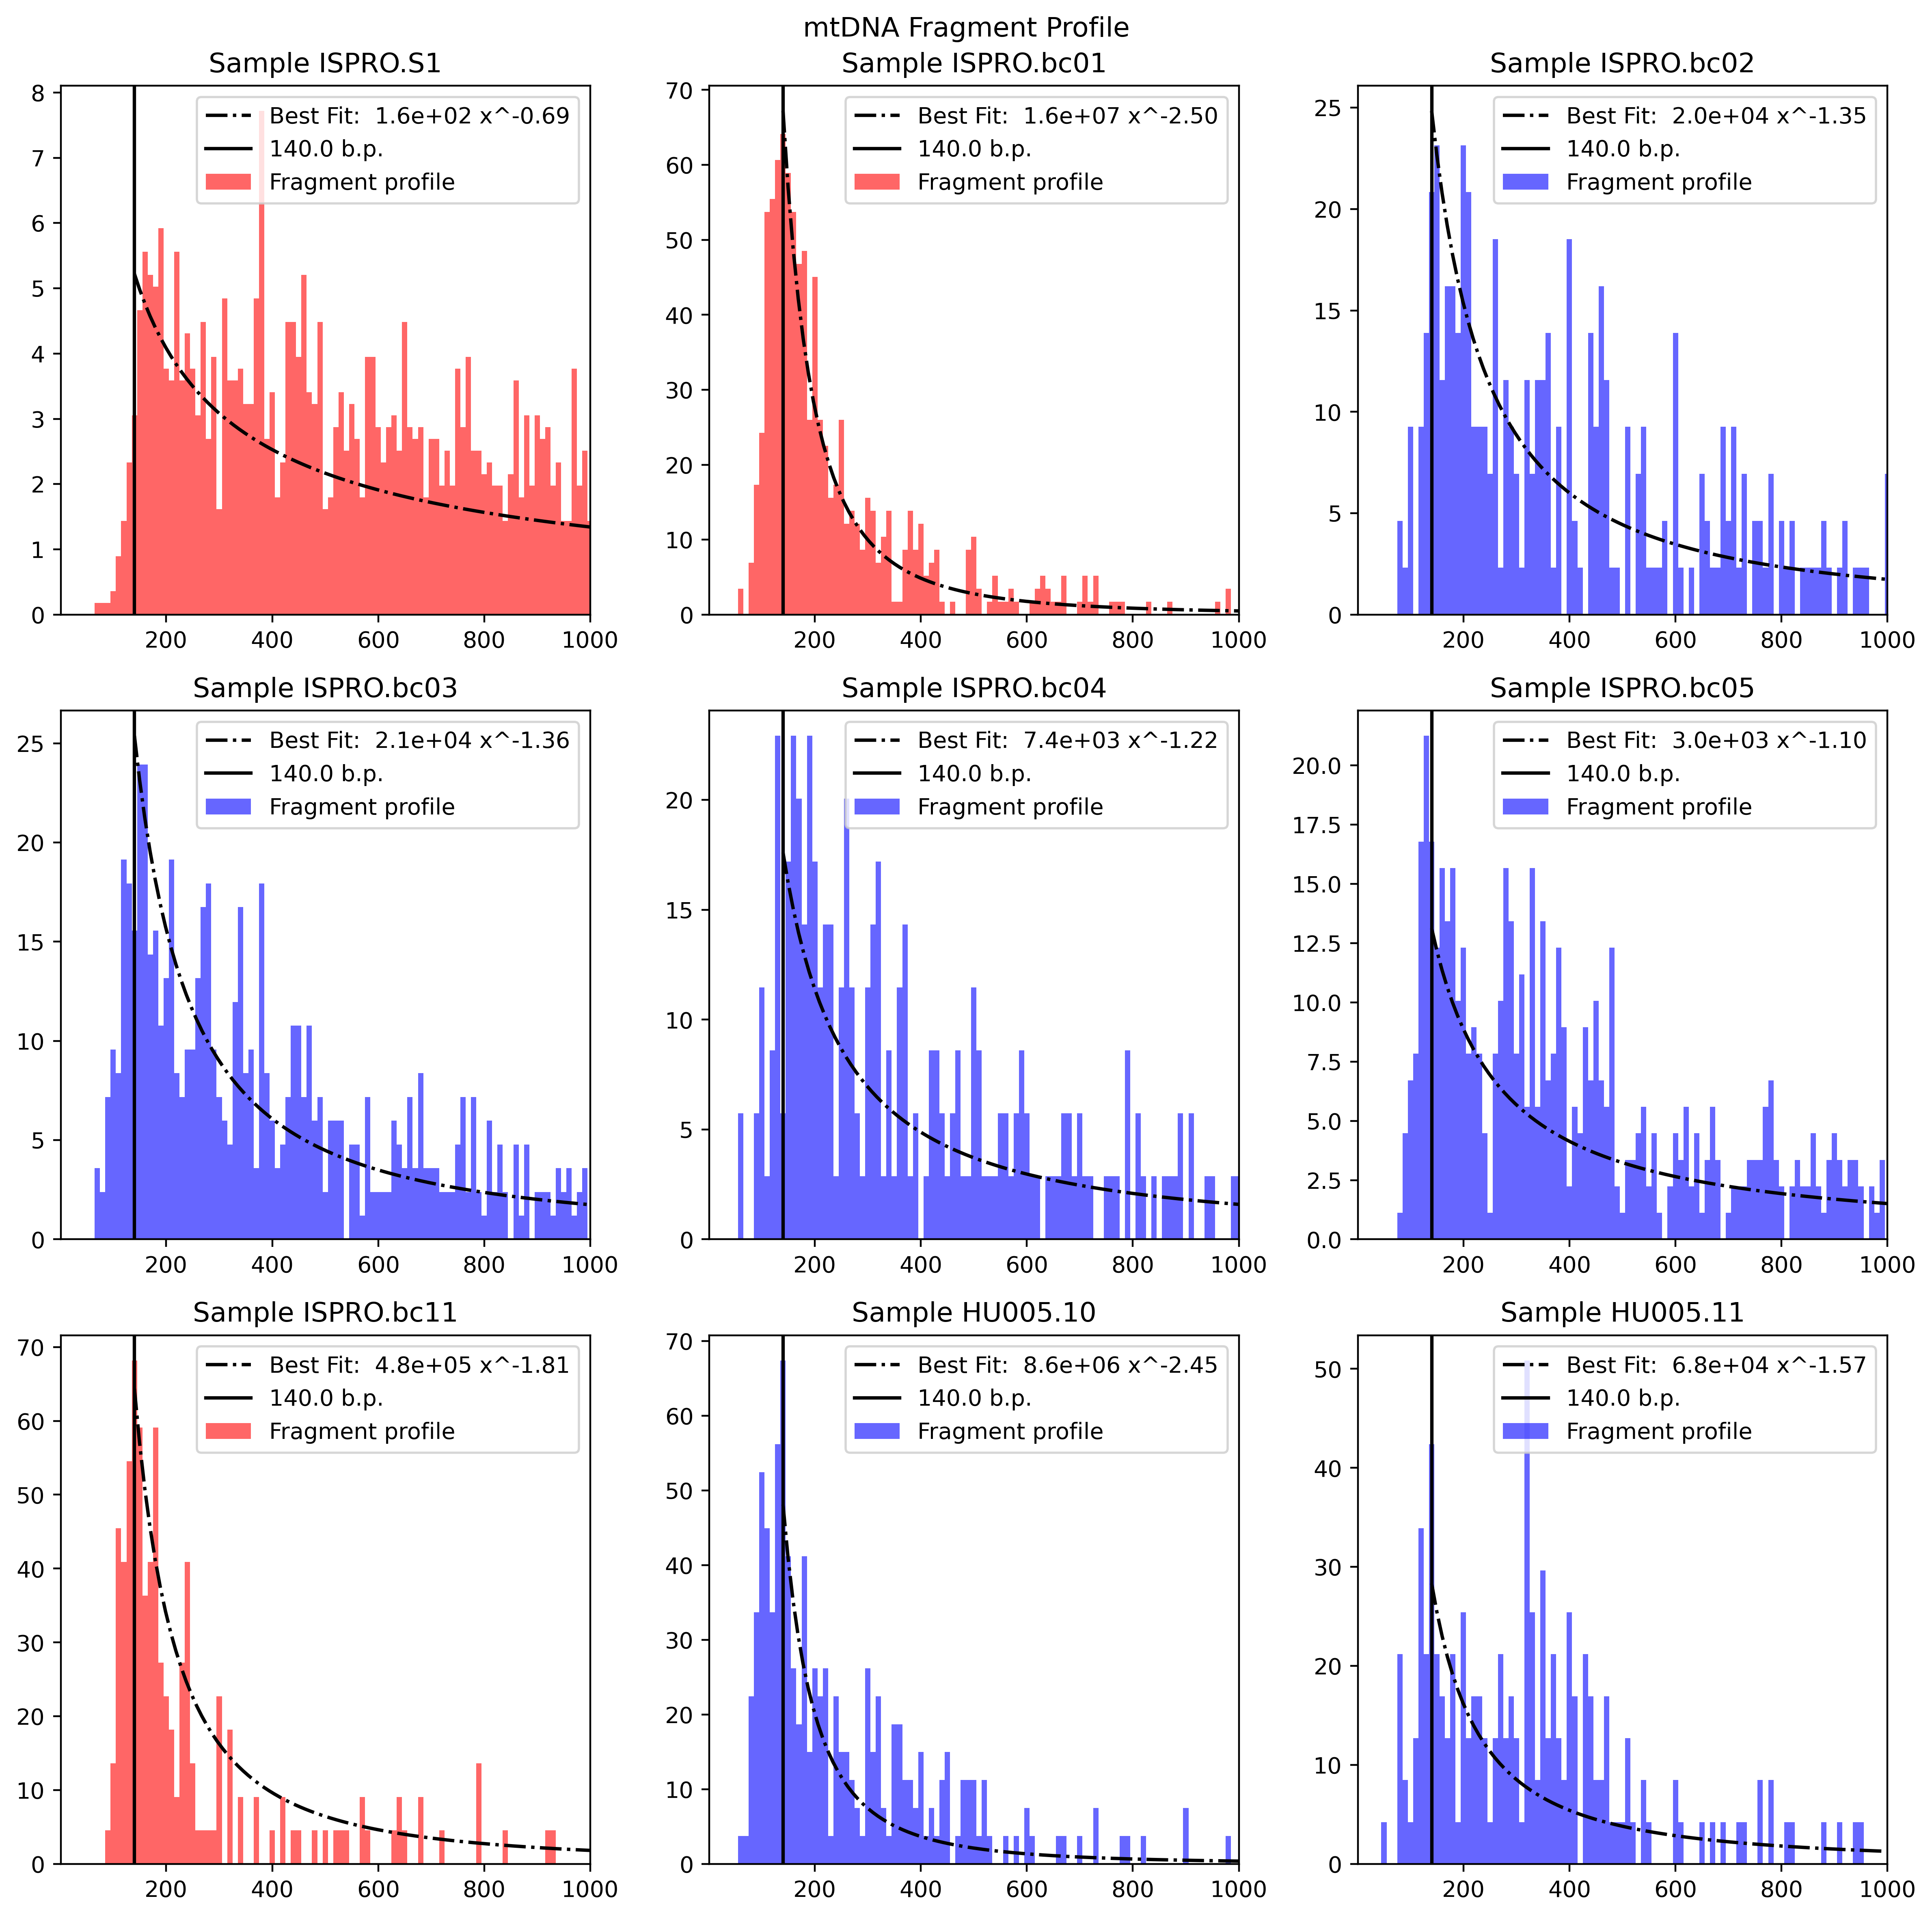

In [24]:
import scipy.interpolate
n = len(mtDNA_id)
fig, ax = plt.subplots(3,3,figsize= (12,12), dpi=400)
counter = 0
bf_coeff = np.zeros((n,2))
low_cutoff=np.ones(n)*140
best_fit_stats = []
for id in mtDNA_id:
    color = mtDNA_color[mtDNA_id.index(id)]
    clin_data_binned = df_mtDNA[df_mtDNA['id']==id]
    mtDNA_bins = clin_data_binned['length_group'].to_numpy()
    y_count = clin_data_binned['freq'].to_numpy()
    ax[int(counter/3),counter%3].bar(mtDNA_bins, y_count/y_count.sum()*1000, width=10, alpha=0.6, color=color, label='Fragment profile')
##############################Linear interpolation of fragment counts to provide best fit coefficients that account for 0 counts #####################################################    
    clin_data = df_chrM[df_chrM['id']==id] 
    x = clin_data['length_group'].to_numpy()
    x= np.append([0],x)
    y = np.cumsum(clin_data['freq'].to_numpy())
    y = np.append([0],y)
    cum_count = np.stack([x,y], axis=0)
    y_interp = scipy.interpolate.interp1d(cum_count[0,:], cum_count[1,:])
    up_idx = np.where(y > np.percentile(y,95))[0].min()
    frag_cutoff = x[up_idx]
    x_axis = np.linspace(0,frag_cutoff,int(frag_cutoff/10)+1)
    y_int = y_interp(x_axis)
    y_lim = y_int[-1]*1.5
    #ax[1,counter].plot(x_axis,y_int, color = 'k', label='linear interpolation')
    #ax[1,counter].bar(x[:up_idx],y[:up_idx],width=10, alpha=0.5, label='cumulative count')
    #ax[1, counter].legend(loc='upper left',fontsize=6)
    #ax[1, counter].set_ylim([0,y_lim])
    freq_int = np.diff(y_int)
    x_max = x_axis[np.where(freq_int == np.max(freq_int))[0]]
    print(id, x_max)
    peak = low_cutoff[counter]
    x_tail = np.linspace(peak,frag_cutoff,int(frag_cutoff/10)+1)
    y_tail = y_interp(x_tail)  
    log_den_trans = np.log(np.diff(y_tail))-np.log(np.diff(y_tail))[0]  #shifting the density point at B_ex to origin
    log_x_axis_trans = np.log(x_tail[1:]) - np.log(x_tail[1]) #shifting the point to origin
    lm = LinearRegression(fit_intercept = False) #apply a linear model with no intercept fit
    lm.fit(log_x_axis_trans.reshape(-1, 1), log_den_trans)
    [m] = lm.coef_
    c = np.log(np.diff(y_tail))[0] - m * np.log(x_tail[1])
    bf_coeff[counter,:] = [m,c]
    print(m,c)
    #plt.plot(x,y/y[-1], label=f'CDF for {id}')
    #plt.title(f'Cumulative Fragment Count for Patients mtDNA')
    #plt.xlabel('Fragment Length (b.p.)')
    #plt.ylabel('Fragment Count')
    #print(np.linspace(0,8000,801),y_int)
    #plt.plot(x,y, label=f'Id: {id}')
    #ax[0, counter].plot(x,y, label=f'Cumulative count')
    #ax[0,counter].set_title(f'Cumulative count, Sample {id}')
    #ax[counter].set_xscale('log')
    #ax[counter].set_yscale('log')
    #ax[int(counter/3),counter%3].set_ylim([0.01,50])
    ax[int(counter/3),counter%3].set_xlim([1,1000])
    ax[int(counter/3),counter%3].plot(x_tail, np.exp(c)*x_tail**m/y_count.sum()*1000, label=f'Best Fit: {np.exp(c)/y_count.sum()*1000: .1e} x^{m: .2f}', color='k', linestyle='-.')
    ax[int(counter/3),counter%3].set_title(f'Sample {id}')
    #ax[counter].set_xlim([100,frag_cutoff])
    ax[int(counter/3),counter%3].axvline(peak, label=f'{peak} b.p.', color='k')
    ax[int(counter/3),counter%3].legend(loc='upper right',fontsize=10)
 
    fig.tight_layout()
    best_fit_stats += [[mtDNA_health[counter], id, m,c]]
    counter +=1
    fig.suptitle('mtDNA Fragment Profile')


#fig.savefig('../data_analysis/population_plot/mtDNA_frag_prof_nanopore.eps')
#fig.savefig('../data_analysis/population_plot/mtDNA_frag_prof_nanopore.png')
fig.savefig('../data_analysis/population_plot/mtDNA_frag_prof_nanopore.pdf')

#fig.savefig('../data_analysis/population_plot/mtDNA_frag_prof_nanopore_loglog.png')

print(bf_coeff)



ISPRO.S1 [370.30976744]
-0.6908030350828819 6.784262717620279
ISPRO.bc01 [130.21812081]
-2.502358609845376 16.023320270906108
ISPRO.bc02 [140.15360502]
-1.3531999639145622 9.06002791256066
ISPRO.bc03 [150.17017828]
-1.3618472468972278 9.784625526912809
ISPRO.bc04 [180.21231979]
-1.2227719992852941 7.857835218482403
ISPRO.bc05 [120.06469003]
-1.1001057040634385 7.898730813972218
ISPRO.bc11 [130.0887372]
-1.806439366469611 11.577203172654237
HU005.10 [130.33333333]
-2.4463333938527345 14.641809839890417
HU005.11 [310.13716814]
-1.5745341472947225 9.680658477344378
[[-0.69080304  6.78426272]
 [-2.50235861 16.02332027]
 [-1.35319996  9.06002791]
 [-1.36184725  9.78462553]
 [-1.222772    7.85783522]
 [-1.1001057   7.89873081]
 [-1.80643937 11.57720317]
 [-2.44633339 14.64180984]
 [-1.57453415  9.68065848]]


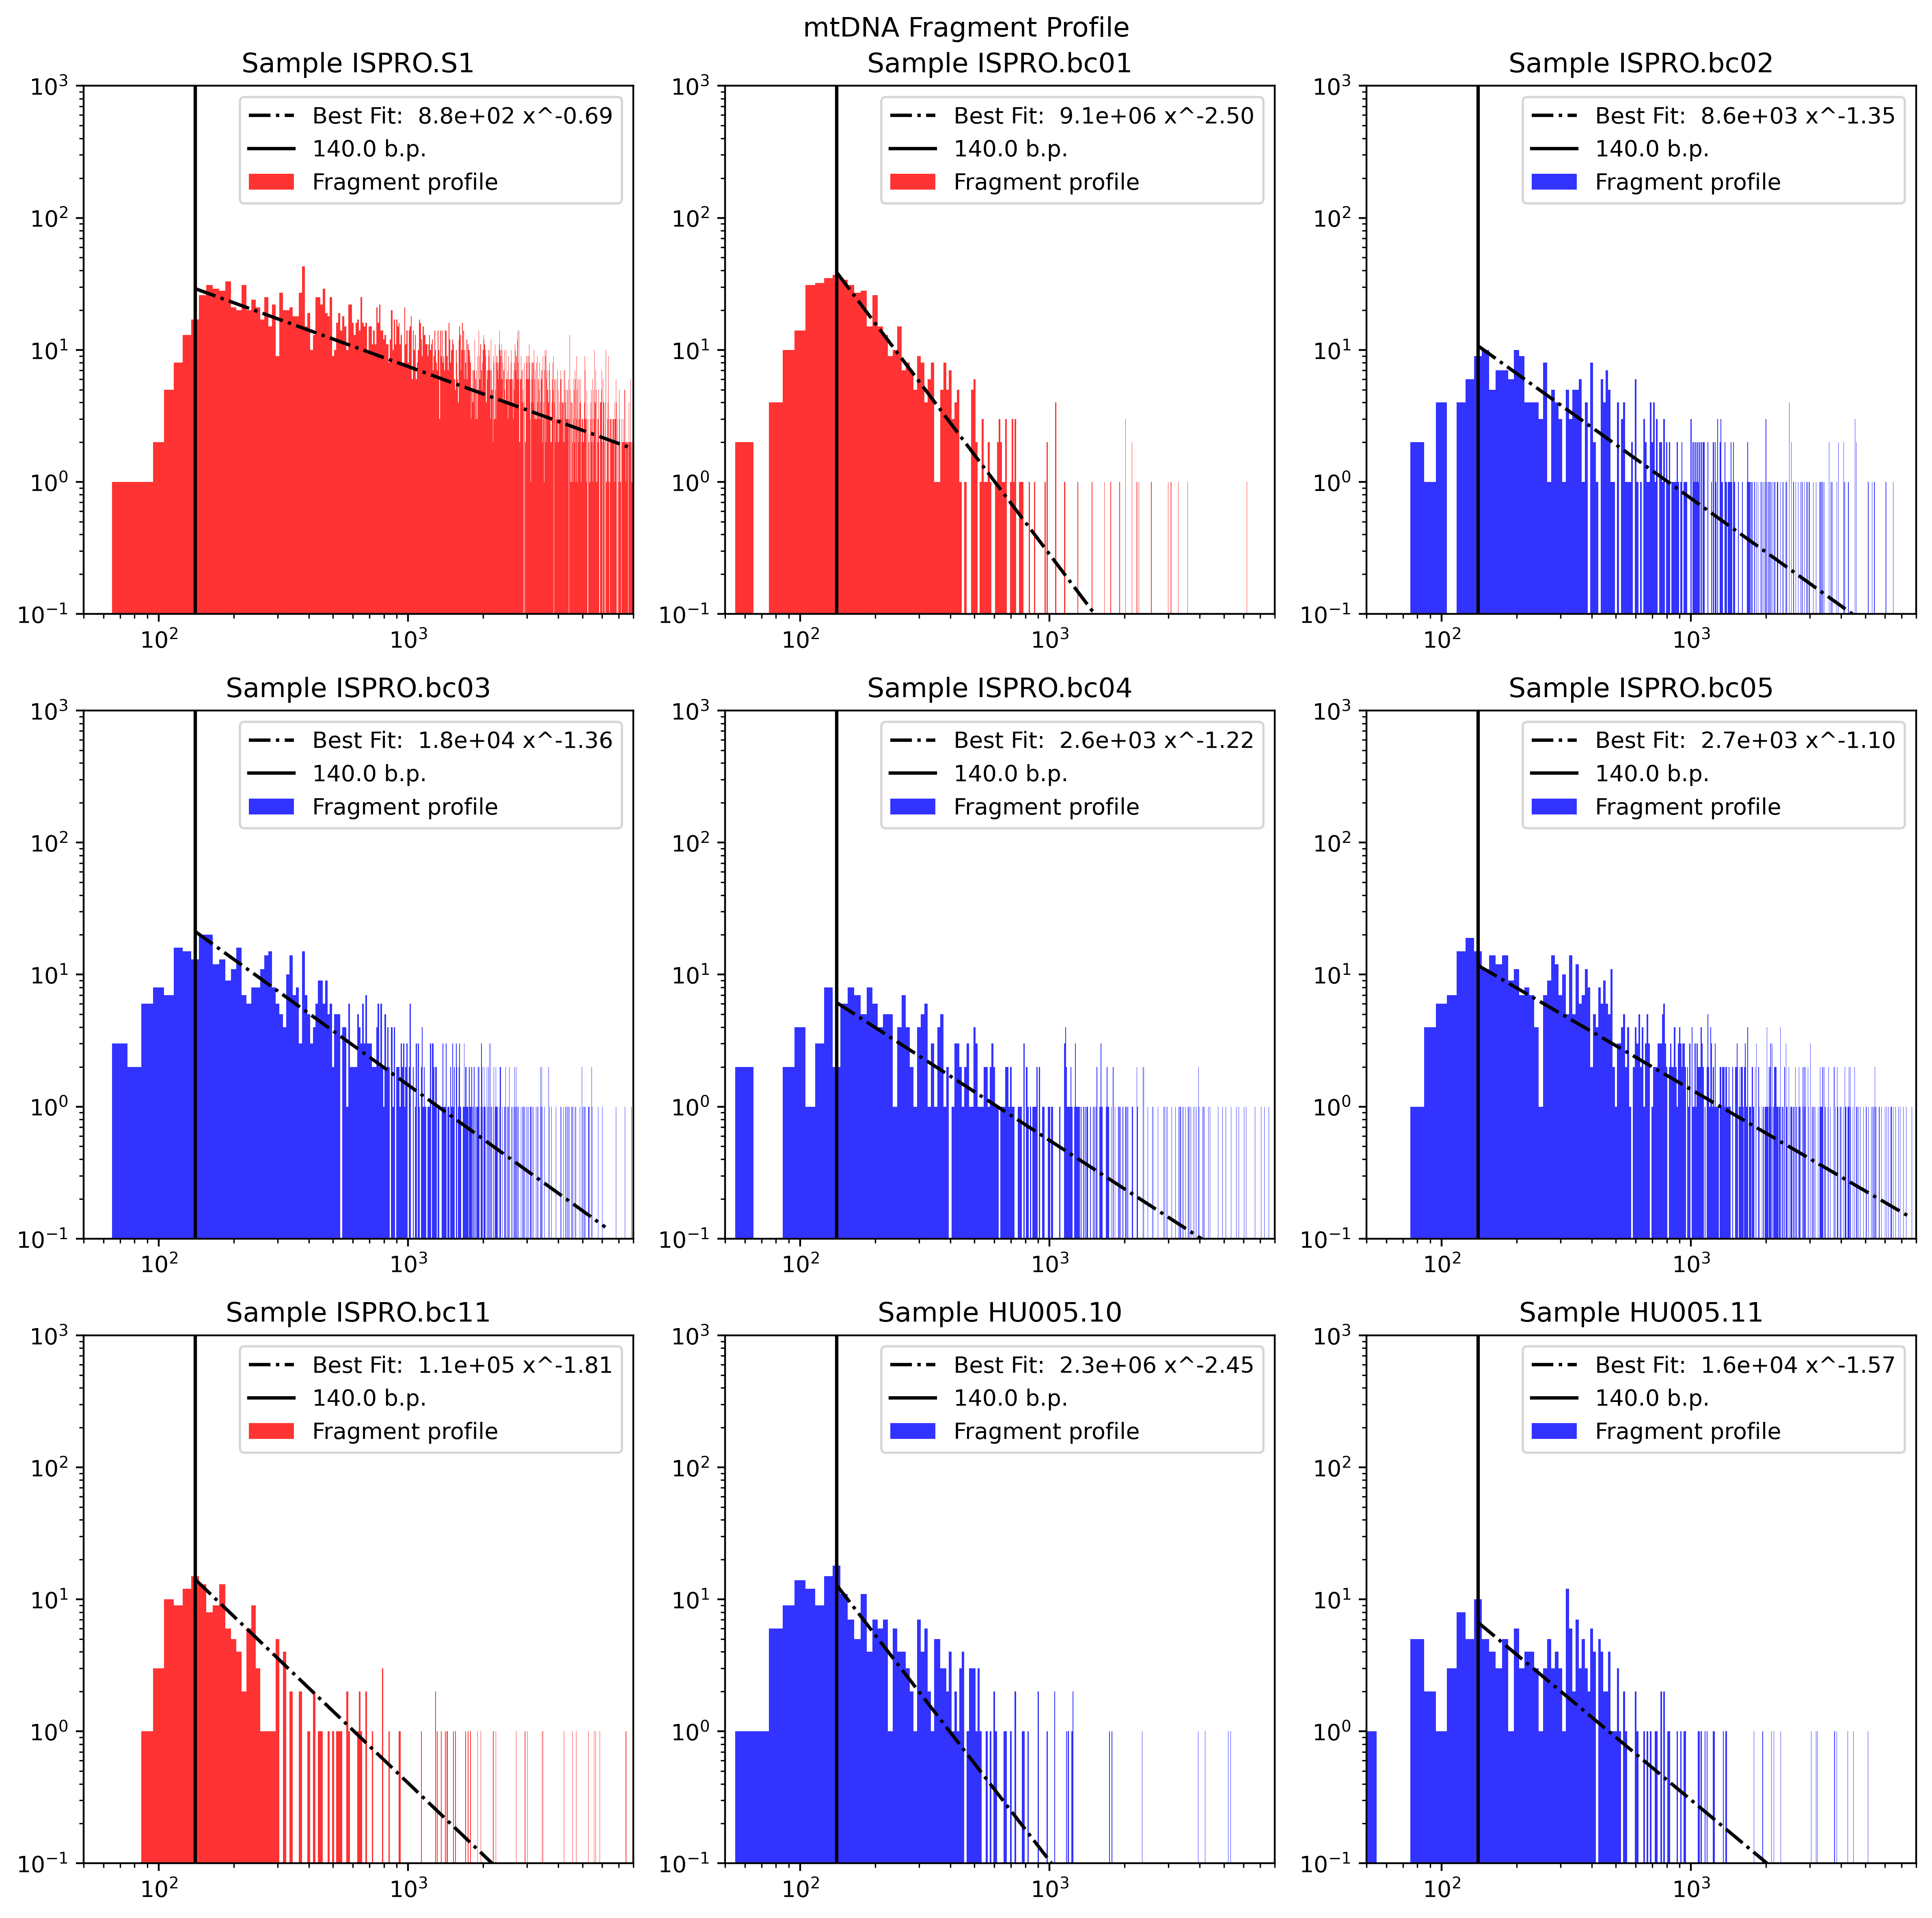

In [11]:
import scipy.interpolate
fig, ax = plt.subplots(3,3,figsize= (12,12), dpi=400)
counter = 0
bf_coeff = np.zeros((n,2))
low_cutoff=np.ones(n)*140
best_fit_stats = []
for id in mtDNA_id:
    color = mtDNA_color[mtDNA_id.index(id)]
    clin_data_binned = df_mtDNA[df_mtDNA['id']==id]
    mtDNA_bins = clin_data_binned['length_group'].to_numpy()
    y_count = clin_data_binned['freq'].to_numpy()
    ax[int(counter/3),counter%3].bar(mtDNA_bins, y_count, width=10, alpha=0.8, color=color, label='Fragment profile')
##############################Linear interpolation of fragment counts to provide best fit coefficients that account for 0 counts #####################################################    
    clin_data = df_chrM[df_chrM['id']==id] 
    x = clin_data['length_group'].to_numpy()
    x= np.append([0],x)
    y = np.cumsum(clin_data['freq'].to_numpy())
    y = np.append([0],y)
    cum_count = np.stack([x,y], axis=0)
    y_interp = scipy.interpolate.interp1d(cum_count[0,:], cum_count[1,:])
    up_idx = np.where(y > np.percentile(y,95))[0].min()
    frag_cutoff = x[up_idx]
    x_axis = np.linspace(0,frag_cutoff,int(frag_cutoff/10)+1)
    y_int = y_interp(x_axis)
    freq_int = np.diff(y_int)
    x_max = x_axis[np.where(freq_int == np.max(freq_int))[0]]
    print(id, x_max)
    peak = low_cutoff[counter]
    x_tail = np.linspace(peak,frag_cutoff,int(frag_cutoff/10)+1)
    y_tail = y_interp(x_tail)  
    log_den_trans = np.log(np.diff(y_tail))-np.log(np.diff(y_tail))[0]  #shifting the density point at B_ex to origin
    log_x_axis_trans = np.log(x_tail[1:]) - np.log(x_tail[1]) #shifting the point to origin
    lm = LinearRegression(fit_intercept = False) #apply a linear model with no intercept fit
    lm.fit(log_x_axis_trans.reshape(-1, 1), log_den_trans)
    [m] = lm.coef_
    c = np.log(np.diff(y_tail))[0] - m * np.log(x_tail[1])
    bf_coeff[counter,:] = [m,c]
    print(m,c)
    #plt.plot(x,y/y[-1], label=f'CDF for {id}')
    #plt.title(f'Cumulative Fragment Count for Patients mtDNA')
    #plt.xlabel('Fragment Length (b.p.)')
    #plt.ylabel('Fragment Count')
    #print(np.linspace(0,8000,801),y_int)
    #plt.plot(x,y, label=f'Id: {id}')
    #ax[0, counter].plot(x,y, label=f'Cumulative count')
    #ax[0,counter].set_title(f'Cumulative count, Sample {id}')
    ax[int(counter/3),counter%3].set_ylim([0.1,1000])
    ax[int(counter/3),counter%3].set_xlim([50,8000])
    ax[int(counter/3),counter%3].set_xscale('log')
    ax[int(counter/3),counter%3].set_yscale('log')
    ax[int(counter/3),counter%3].plot(x_tail, np.exp(c)*x_tail**m, label=f'Best Fit: {np.exp(c): .1e} x^{m: .2f}', color='k', linestyle='-.')
    ax[int(counter/3),counter%3].set_title(f'Sample {id}')
    #ax[counter].set_xlim([100,frag_cutoff])
    ax[int(counter/3),counter%3].axvline(peak, label=f'{peak} b.p.', color='k')
    ax[int(counter/3),counter%3].legend(loc='upper right',fontsize=10)  #ax[1, counter].legend(fontsize=10)
    fig.tight_layout()
    best_fit_stats += [[mtDNA_health[counter], id, m,c]]
    counter +=1
    fig.suptitle('mtDNA Fragment Profile')



#fig.savefig('../data_analysis/population_plot/mtDNA_frag_prof_nanopore_1.png')
#fig.savefig('../data_analysis/population_plot/mtDNA_frag_prof_nanopore_1.pdf')
#fig.savefig('../data_analysis/population_plot/mtDNA_frag_prof_nanopore_loglog.png')
fig.savefig('../data_analysis/population_plot/mtDNA_frag_prof_nanopore_loglog.pdf')

print(bf_coeff)



mtDNA slope mean: -1.56


condition          id  mtDNA slope  mtDNA intercept
0  Lung adenocarcinoma    ISPRO.S1    -0.690803         6.784263
1  Lung adenocarcinoma  ISPRO.bc01    -2.502359        16.023320
2      Healthy control  ISPRO.bc02    -1.353200         9.060028
3      Healthy control  ISPRO.bc03    -1.361847         9.784626
4      Healthy control  ISPRO.bc04    -1.222772         7.857835

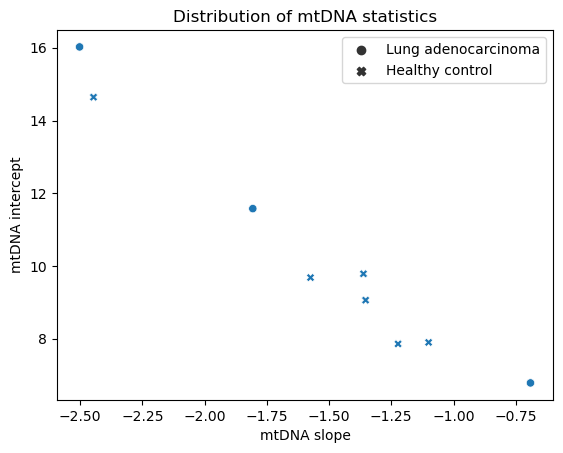

In [12]:

df_bf_mtDNA = pd.DataFrame(best_fit_stats, columns = ['condition','id','mtDNA slope', 'mtDNA intercept'])
mean = df_bf_mtDNA['mtDNA slope'].mean()
print(f'mtDNA slope mean: {mean: .2f}')
g2 = sns.scatterplot(data=df_bf_mtDNA, x='mtDNA slope', y='mtDNA intercept', style= 'condition')
g2.set(title='Distribution of mtDNA statistics')
g2.legend(fontsize=10)
#plt.savefig('../data_analysis/population_plot/mtDNA_stats_dist.eps')
#plt.savefig('../data_analysis/population_plot/mtDNA_stats_dist.png')
plt.savefig('../data_analysis/population_plot/mtDNA_stats_dist.pdf')

df_bf_mtDNA.head()



## gDNA Fragment Profile Curve-fitting analysis

### Per Patient Visualisation

Lung adenocarcinoma
Lung adenocarcinoma
Healthy control
Healthy control
Healthy control
Healthy control
Lung adenocarcinoma
Lung adenocarcinoma
Lung adenocarcinoma
Lung adenocarcinoma
Healthy control
Healthy control
Healthy control


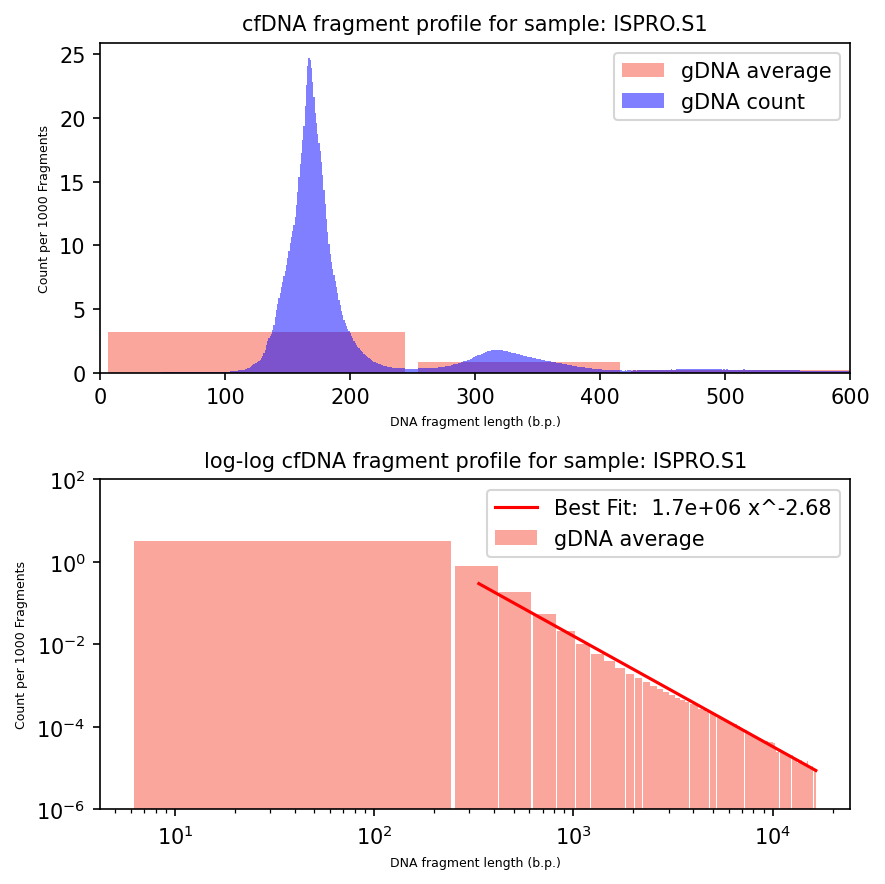

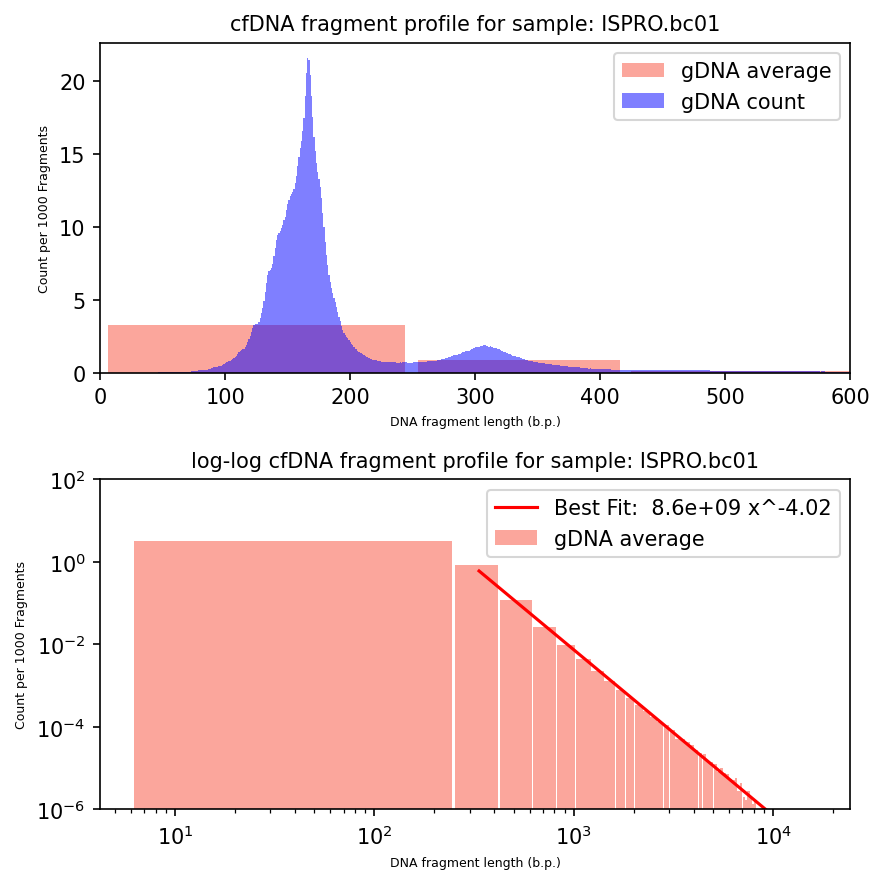

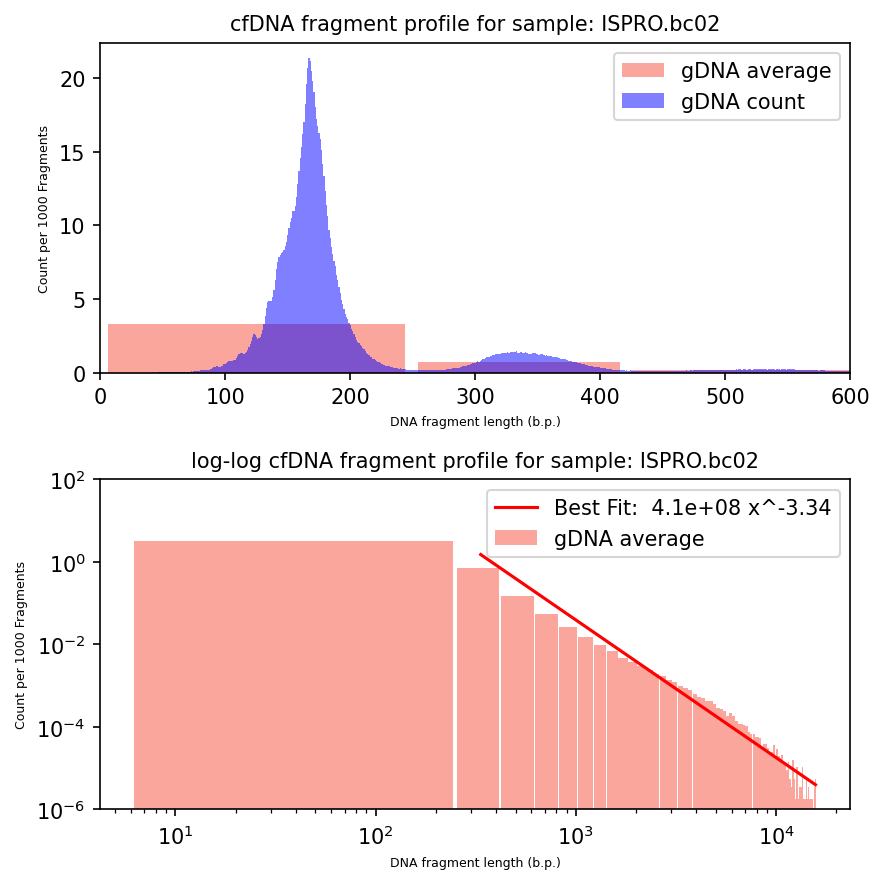

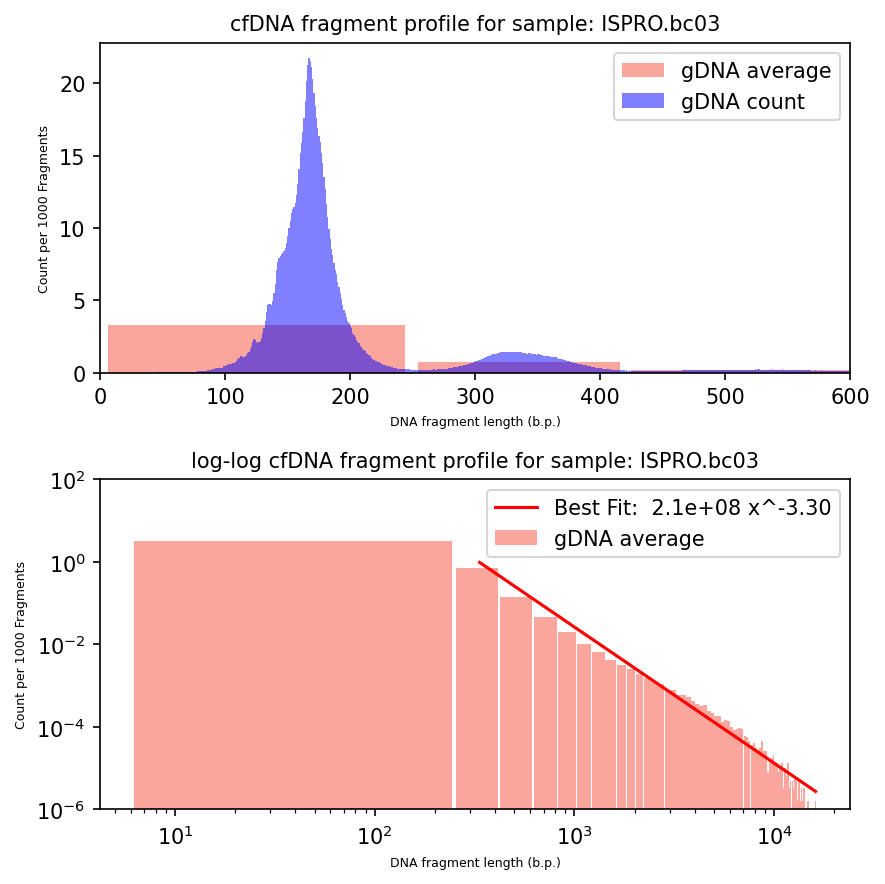

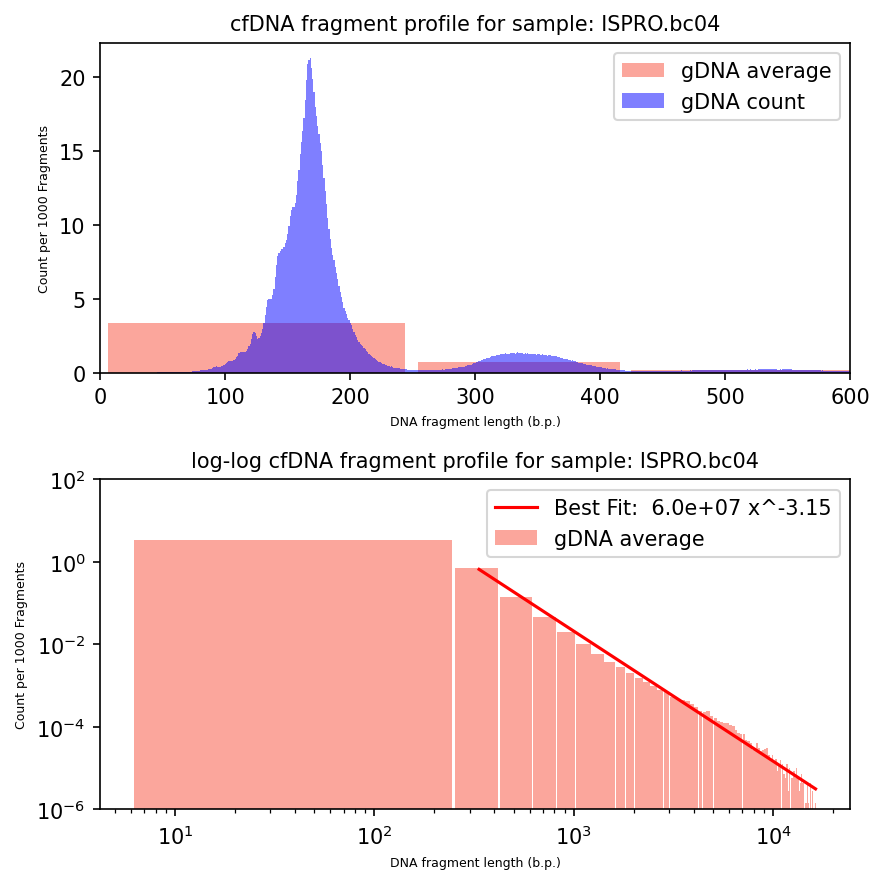

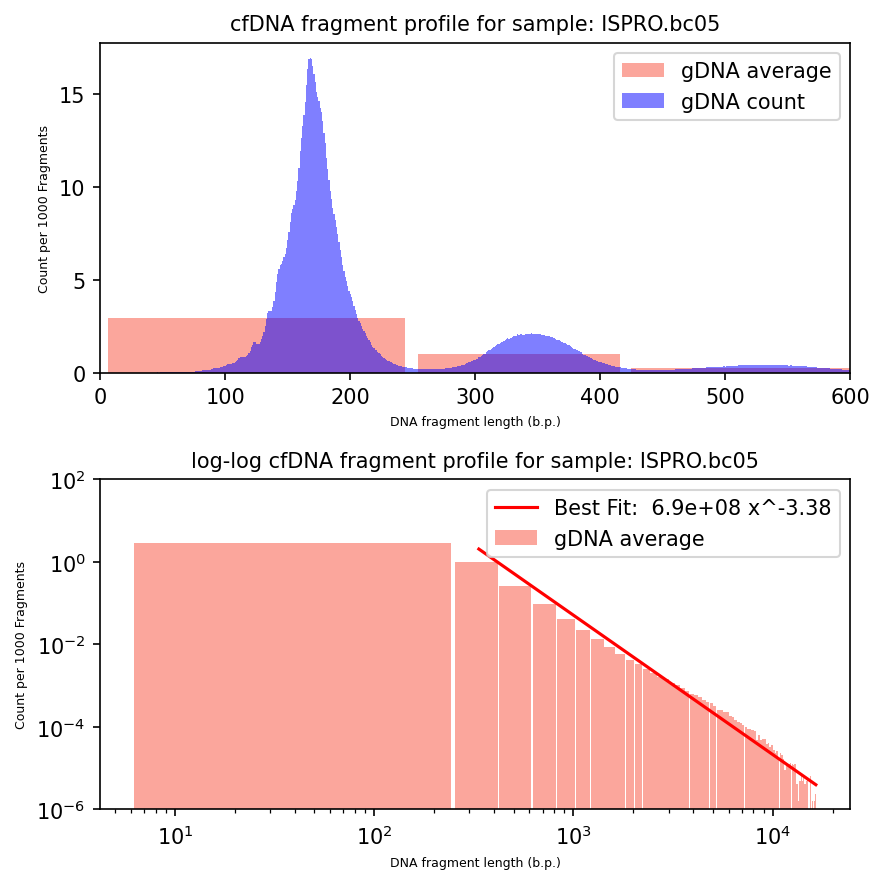

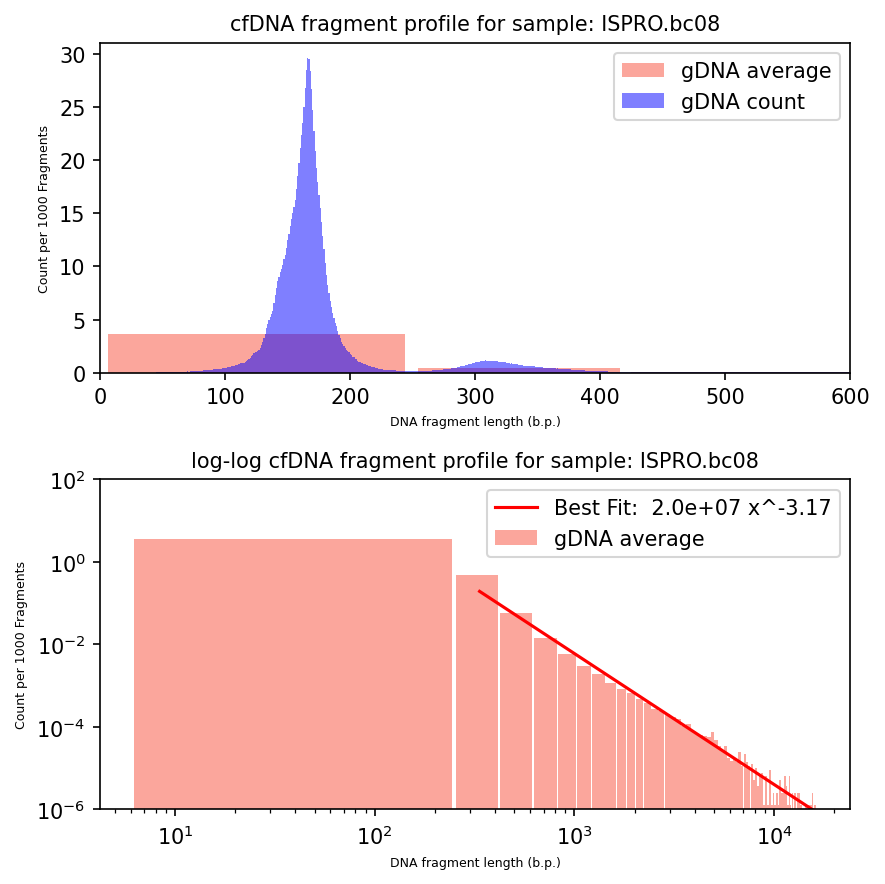

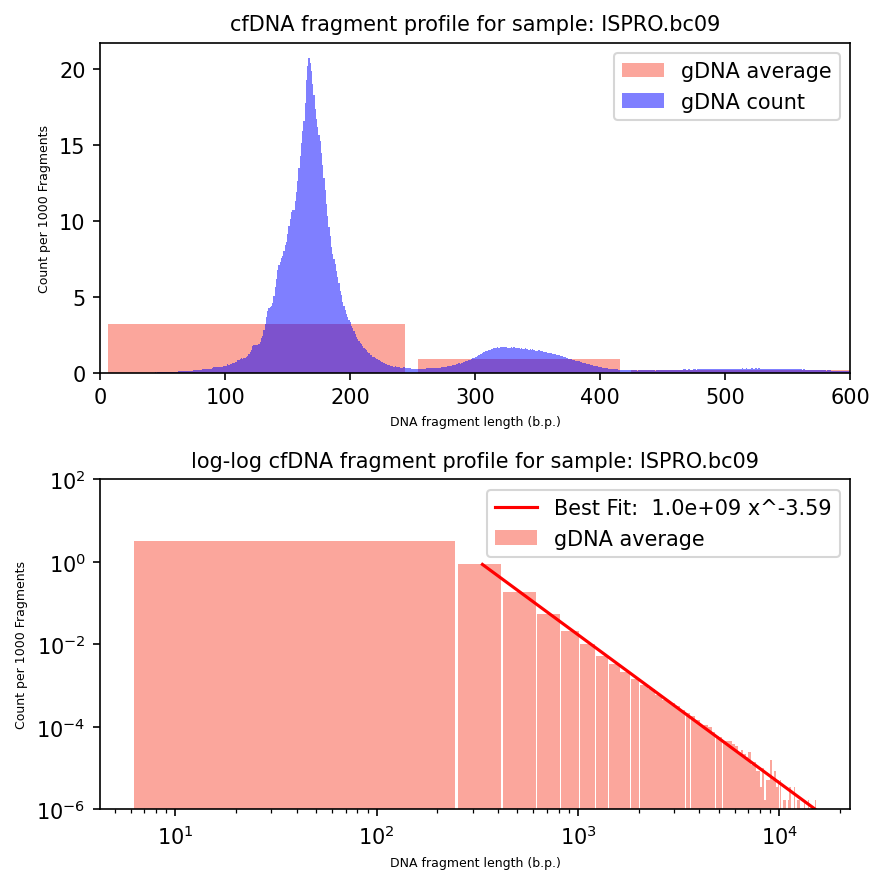

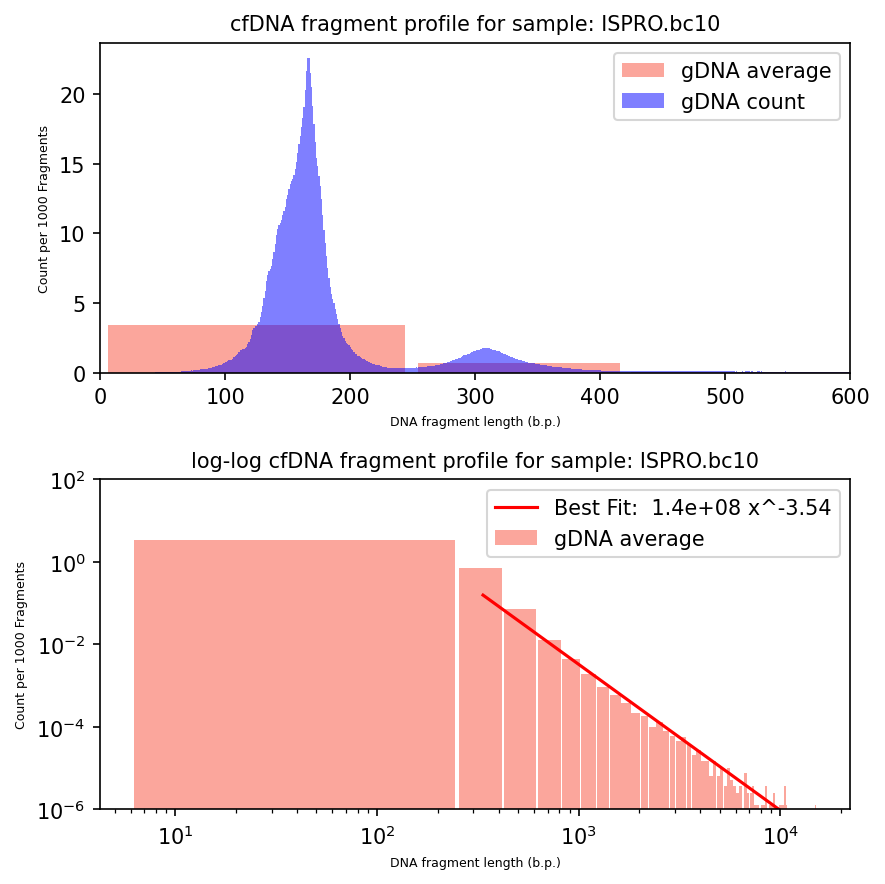

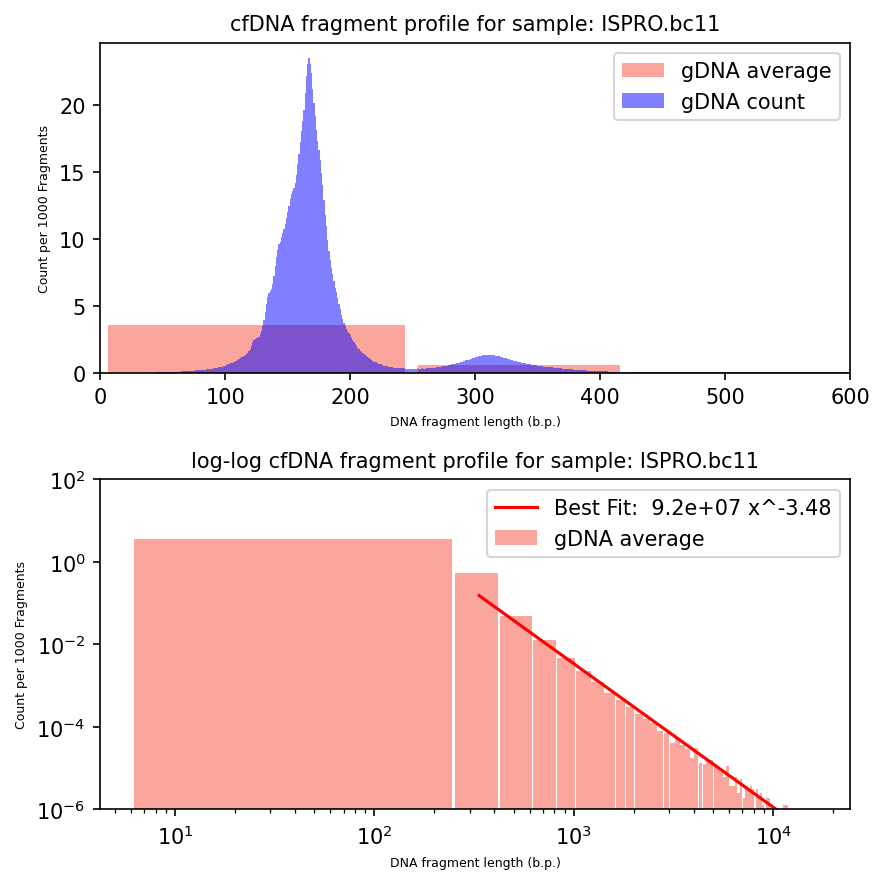

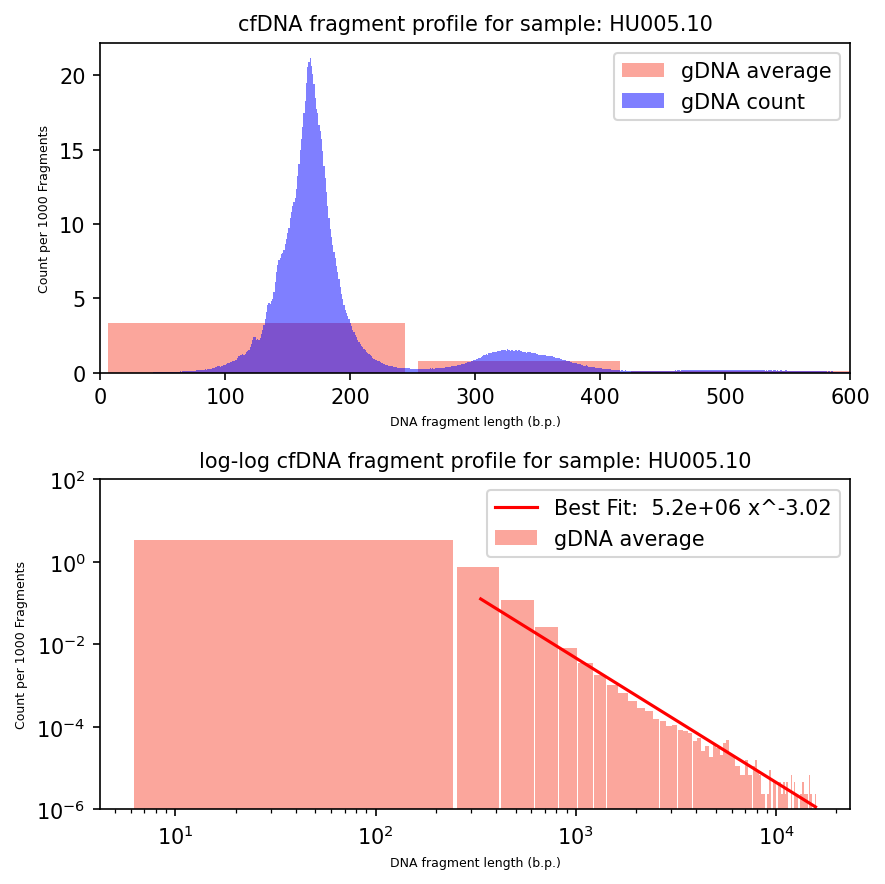

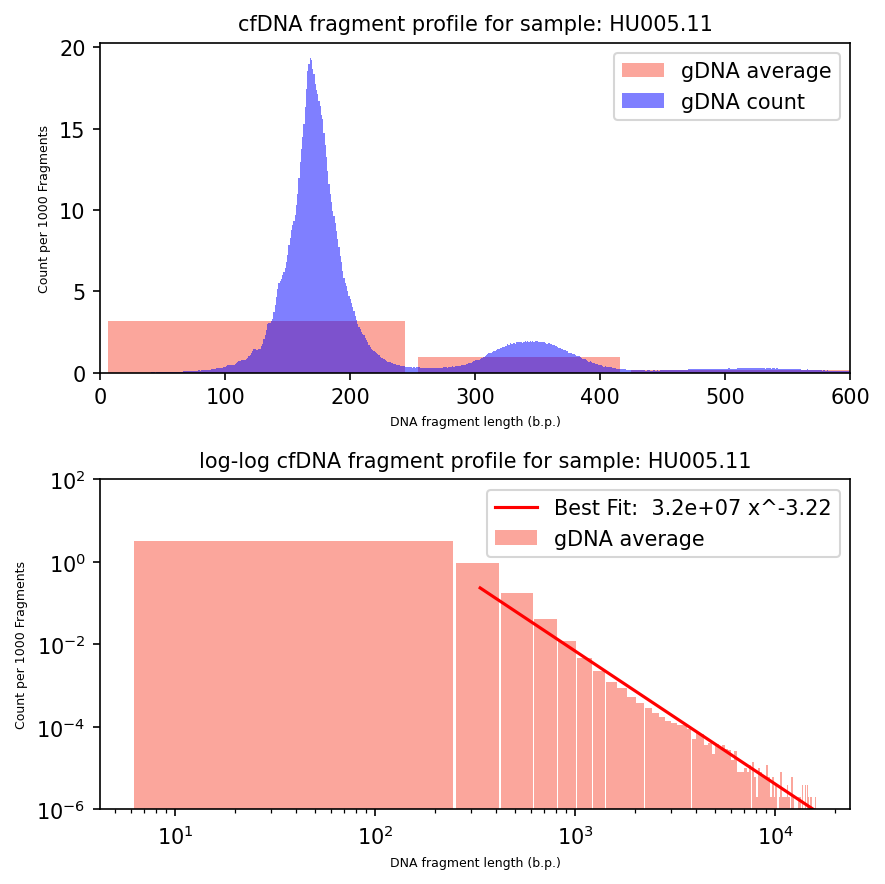

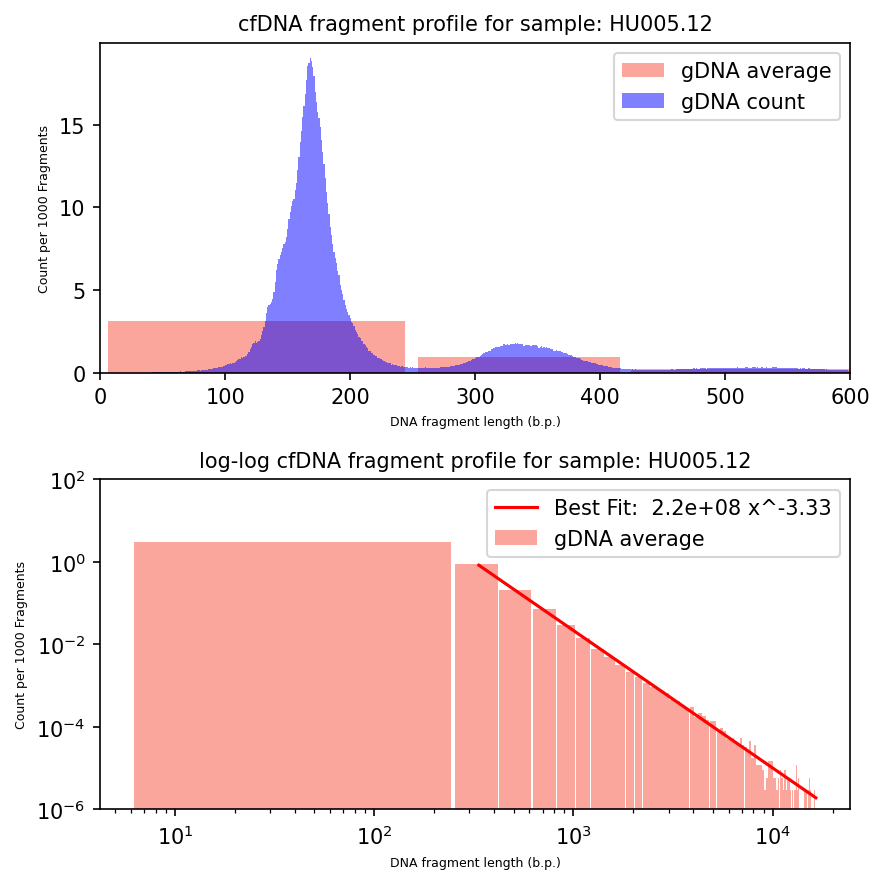

In [14]:
best_fit_stats = []


for id in id_list:
    fig, ax = plt.subplots(2, dpi=150, figsize=[6,6])
    df_id_gDNA = df_gDNA[df_gDNA['id']==id]
    [id_health]=df_id_gDNA.condition.unique()
    print(id_health)
    avg_count = df_id_gDNA['freq'].to_numpy()/(df_id_gDNA['freq'].sum()*df_id_gDNA['length_width'])*1000
    avg_bin = df_id_gDNA['length_group'].to_numpy()
    m_0,c_0 = np.polyfit(np.log(avg_bin[1:]),np.log(avg_count[1:]),1)
    #gDNA_tail = df_id_gDNA[df_id_gDNA['length_group']>=167]
    #gDNA_tail_length = gDNA_tail['length_group'].to_numpy()
    #gDNA_tail_count = gDNA_tail['freq'].to_numpy()/(gDNA_tail['freq'].sum()*gDNA_tail['length_width'])*1000
    #m_0, c_0 = np.polyfit(np.log(gDNA_tail_length),np.log(gDNA_tail['freq'].to_numpy()),1)
    
    clin_data_full = df_gDNA_full[df_gDNA_full['id']==id]
    clin_data_full = clin_data_full[clin_data_full['length']<=10000]
    clin_data_full.sort_values(by='length')
    clin_length_full = clin_data_full['length'].to_numpy()
    clin_freq_full = clin_data_full['freq'].to_numpy()    
    
    ax[0].set_title('cfDNA fragment profile for sample: ' + id, fontsize=10)
    #print(df_id_gDNA['length_group'].to_numpy())
    ax[0].bar(x=avg_bin, height=avg_count,label='gDNA average', alpha=0.7, color='salmon', width = df_id_gDNA['length_width'].to_numpy()*0.95)
    #ax[0].scatter(gDNA_tail_length, np.exp(c_0)*gDNA_tail_length**m_0,label=f'Best Fit: {np.exp(c_0): .1e}x^{m_0: .2f}', color = 'k', s=0.5)
    ax[0].set_xlabel('DNA fragment length (b.p.)', fontsize=6)
    ax[0].set_xlim([0,600])
    ax[0].bar(clin_length_full,clin_freq_full/np.sum(clin_freq_full)*1000, label=f"gDNA count", width=1, alpha=0.5, color = 'b')
    #ax[0].set_yscale('log')
    #ax[0].bar(x=df_id_chrM['length_group'].to_numpy(), height=df_id_chrM['freq'].to_numpy(),label='mtDNA',width=0.8*len_grp_size, alpha=1, color='blue')
    #ax[0].plot(chrM_tail_length, np.exp(c_1)*chrM_tail_length**m_1,label=f'mtDNA count best fit curve: {np.exp(c_1): .1e}x^{m_1: .2f}', color = 'darkblue')
    ax[0].set_ylabel('Count per 1000 Fragments', fontsize=6)
    ax[0].legend(loc='upper right',fontsize=10)

    ax[1].set_title('log-log cfDNA fragment profile for sample: ' + id, fontsize=10)
    ax[1].bar(x=avg_bin, height=avg_count,label='gDNA average', alpha=0.7, color='salmon', width=df_id_gDNA['length_width'].to_numpy()*0.95)
    ax[1].plot(avg_bin[1:], np.exp(c_0)*avg_bin[1:]**m_0, color = 'red', label=f'Best Fit: {np.exp(c_0): .1e} x^{m_0: .2f}')
    ax[1].set_xlabel('DNA fragment length (b.p.)', fontsize=6)
    #ax[1].bar(x=df_id_chrM['length_group'].to_numpy(), height=df_id_chrM['freq'].to_numpy(),label='mtDNA',width=0.8*len_grp_size, alpha=1, color='blue')
    #ax[1].plot(chrM_tail_length, np.exp(c_1)*chrM_tail_length**m_1,label=f'log y = {c_1: .1e}+ {m_1: .2f} log x', color = 'darkblue')
    ax[1].set_ylabel('Count per 1000 Fragments', fontsize=6)
    ax[1].legend(loc='upper right',fontsize=10)
    ax[1].set_yscale('log')
    ax[1].set_xscale('log')
    ax[1].set_ylim([10**-6,10**2])
    best_fit_stats += [[id_health, id, m_0,c_0]]
    #ax1[id_list.index(id)].legend(fontsize=10)
    #fig1.suptitle('Mitochondrial cfDNA fragment profile for healthy patients', fontsize =30)
    fig.tight_layout()
    path = r'../data_analysis/ind_plot'
    fig_name = str(id) +'_ind_plt'
    #fig.savefig(path + '/'+ fig_name +'.eps', transparent=False)
    #fig.savefig(path + '/'+ fig_name +'.png', transparent=False)  
    fig.savefig(path + '/'+ fig_name +'.pdf', transparent=True)  





### All Samples in One Picture

Lung adenocarcinoma
Lung adenocarcinoma
Healthy control
Healthy control
Healthy control
Healthy control
Lung adenocarcinoma
Lung adenocarcinoma
Lung adenocarcinoma
Lung adenocarcinoma
Healthy control
Healthy control
Healthy control


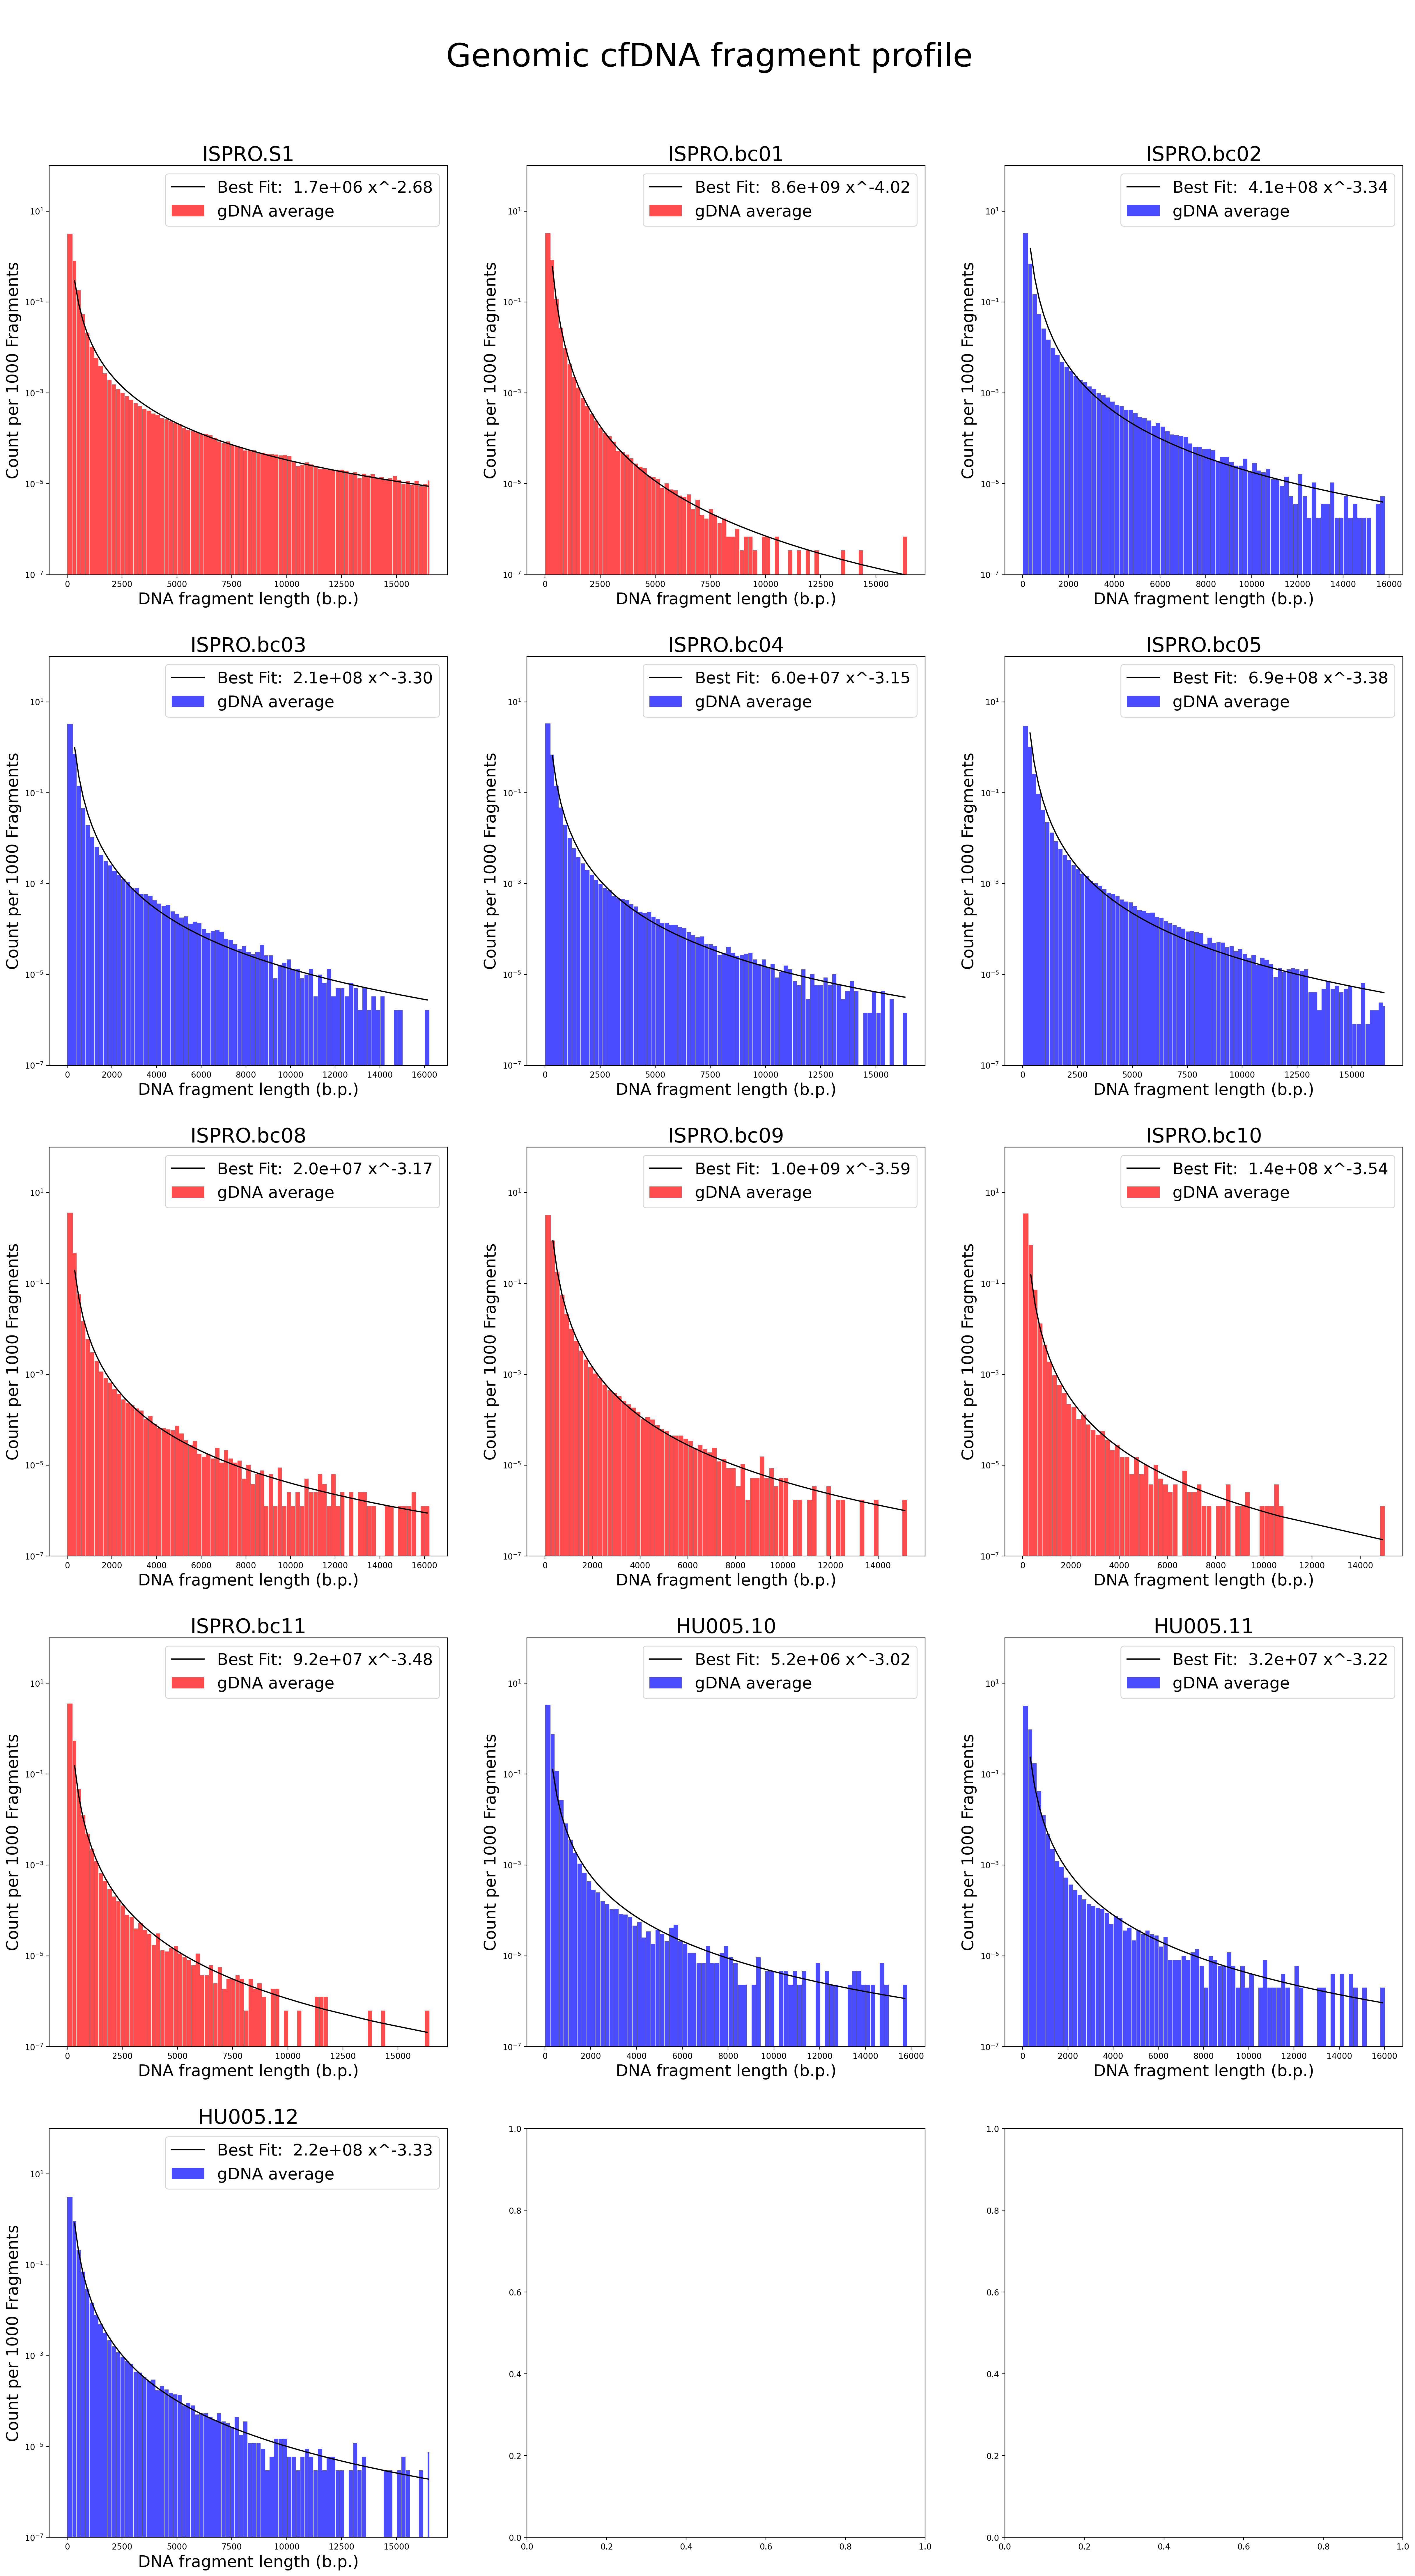

In [15]:
fig, ax = plt.subplots(5,3, dpi=200, figsize=[30,50])
counter=0
fig.suptitle('\n Genomic cfDNA fragment profile', fontsize =40)

for id in id_list:
    color = gDNA_color[gDNA_id.index(id)]
    df_id_gDNA = df_gDNA[df_gDNA['id']==id]
    [id_health]=df_id_gDNA.condition.unique()
    print(id_health)
    avg_count = df_id_gDNA['freq'].to_numpy()/(df_id_gDNA['freq'].sum()*df_id_gDNA['length_width'])*1000
    avg_bin = df_id_gDNA['length_group'].to_numpy()
    m_0,c_0 = np.polyfit(np.log(avg_bin[1:]),np.log(avg_count[1:]),1)
    #gDNA_tail = df_id_gDNA[df_id_gDNA['length_group']>=167]
    #gDNA_tail_length = gDNA_tail['length_group'].to_numpy()
    #gDNA_tail_count = gDNA_tail['freq'].to_numpy()/(gDNA_tail['freq'].sum()*gDNA_tail['length_width'])*1000
    #m_0, c_0 = np.polyfit(np.log(gDNA_tail_length),np.log(gDNA_tail['freq'].to_numpy()),1)
    
    clin_data_full = df_gDNA_full[df_gDNA_full['id']==id]
    clin_data_full = clin_data_full[clin_data_full['length']<=10000]
    clin_data_full.sort_values(by='length')
    clin_length_full = clin_data_full['length'].to_numpy()
    clin_freq_full = clin_data_full['freq'].to_numpy()    
    
    ax[int(counter/3),counter%3].set_title(id, fontsize=25)
    ax[int(counter/3),counter%3].bar(x=avg_bin, height=avg_count,label='gDNA average', alpha=0.7, color=color, width=df_id_gDNA['length_width'].to_numpy()*0.95)
    ax[int(counter/3),counter%3].plot(avg_bin[1:], np.exp(c_0)*avg_bin[1:]**m_0, color = 'k', label=f'Best Fit: {np.exp(c_0): .1e} x^{m_0: .2f}')
    ax[int(counter/3),counter%3].set_xlabel('DNA fragment length (b.p.)', fontsize=20)
    #ax[1].bar(x=df_id_chrM['length_group'].to_numpy(), height=df_id_chrM['freq'].to_numpy(),label='mtDNA',width=0.8*len_grp_size, alpha=1, color='blue')
    #ax[1].plot(chrM_tail_length, np.exp(c_1)*chrM_tail_length**m_1,label=f'log y = {c_1: .1e}+ {m_1: .2f} log x', color = 'darkblue')
    ax[int(counter/3),counter%3].set_ylabel('Count per 1000 Fragments', fontsize=20)
    ax[int(counter/3),counter%3].legend(loc='upper right', fontsize=20)
    ax[int(counter/3),counter%3].set_yscale('log')
    ax[int(counter/3),counter%3].set_ylim([10**-7,10**2])
    counter+=1
    #ax1[id_list.index(id)].legend(fontsize=10)
    #fig1.suptitle('Mitochondrial cfDNA fragment profile for healthy patients', fontsize =30)

#fig.tight_layout()
fig.subplots_adjust(top=0.925)
path = r'../data_analysis/population_plot'
#fig.savefig(path + '/gDNA_frag_prof_nanopore.png', transparent=False)
#fig.savefig(path + '/gDNA_frag_prof_nanopore.eps', transparent=False) 
fig.savefig(path + '/gDNA_frag_prof_nanopore.pdf', transparent=False)



### Scatter Plots of Fragment Profile Statistics

In [ ]:
df_bf_gDNA = pd.DataFrame(best_fit_stats, columns = ['condition','id','gDNA slope', 'gDNA intercept'])
df_bf_gDNA.to_csv('../data_analysis/params/gDNA_best_fit_coeff.csv')

In [ ]:
g1 = sns.scatterplot(data=df_bf_gDNA, x='gDNA slope', y='gDNA intercept', hue='condition')
mean = df_bf_gDNA['gDNA slope'].mean()
print(f'gDNA slope mean: {mean: .2f}')
g1.set(title='Distribution of gDNA statistics')
g1.legend(loc='upper right',bbox_to_anchor=(1, 0.8))
#plt.savefig(path + '/gDNA_stats_dist_nanopore.png')
#plt.savefig(path + '/gDNA_stats_dist_nanopore.eps')
plt.savefig(path + '/gDNA_stats_dist_nanopore.pdf')



### mtDNA gDNA comparison

In [ ]:
df_bf_gDNA['DNA']='gDNA'
display(df_bf_gDNA)
df_bf_gDNA = df_bf_gDNA.rename(columns={"gDNA slope": "slope", "gDNA intercept": "intercept"})
display(df_bf_gDNA)
df_bf_mtDNA['DNA']='mtDNA'
df_bf_mtDNA = df_bf_mtDNA.rename(columns={"mtDNA slope": "slope", "mtDNA intercept": "intercept"})
df_bf=pd.concat([df_bf_gDNA,df_bf_mtDNA])
display(df_bf)

In [ ]:

g2 = sns.scatterplot(data=df_bf, x='slope', y='intercept', style='condition', hue='DNA')
g2.set(title='gDNA slope vs mtDNA slope')
g2.legend(loc='upper right',bbox_to_anchor=(1, 0.8))
#plt.savefig(path + '/mtDNA_gDNA_slope.png')
#plt.savefig(path + '/mtDNA_gDNA_slope.eps')
plt.savefig(path + '/mtDNA_gDNA_slope.pdf')



## mtDNA FRIME Best Fit Simulation

We now try to use our FRIME process simulation to simulate the fragment profiles.

We only work on 4 fragment profiles with more than 500 fragment counts for accurate statistical inference.





In [ ]:
## Printing lists of id with 500+ mtDNA fragments

mtDNA_id_500 = []
for id in id_list:
    #id = 'ISPRO.bc05'
    clin_data = df_chrM[df_chrM['id']==id] #chrM
    health = clin_data['condition'].iloc[0]
    x = clin_data['length_group'].to_numpy()
    x= np.append([0],x)
    y = np.cumsum(clin_data['freq'].to_numpy())
    if y[-1] >= 500:
        #print(id, y[-1], clin_data['condition'])
        mtDNA_id_500 += [id]
print(f'ID list: {mtDNA_id_500}')


In [ ]:
#Only use the following two lines to re-create a new sim_clin_df file
sim_clin_df = pd.DataFrame(columns = ['time','id','clin_list','sim_list','seed','N_event','KS_dist','p-value','ex_max','ex_slope','frag_speed','N_split','a','b','alpha_f','Nimm','imm_rate','lin_ex','B_ex','alpha_e','x_max'])
sim_clin_df.to_csv('../data_analysis/params/sim_clin.csv', index=False)


sim_clin_df = pd.read_csv('../data_analysis/params/sim_clin.csv')
display(sim_clin_df)


### Best Fit for Sample 'ISPRO.bc05'

In [ ]:
from frime import *
from itertools import groupby
id = 'ISPRO.bc05'
clin_data = df_chrM[df_chrM['id']==id] #chrM
clin_data = clin_data[clin_data['length_group']<=10000]
#clin_data = df_gDNA[df_gDNA['id']==id] #gDNA
display(clin_data)
clin_data = clin_data.sort_values('length_group') #For chrM Data
#clin_data = clin_data.sort_values('length') #For gDNA Data
clin_data['cumsum']=clin_data['freq'].cumsum()
clin_cum = clin_data[['length_group','cumsum']].to_numpy() #chrM
#clin_cum = clin_data[['length','cumsum']].to_numpy() #gDNA
clin_cum = np.append([[0,0]],clin_cum, axis=0)


############## Writing the cumulative count function from frequency table ##############################
#x_max = clin_data['length'].max() #gDNA
x_max = clin_data['length_group'].max() #mtDNA
clin_ccf = np.zeros(x_max+1)
for i in range(np.shape(clin_cum)[0]):
    clin_ccf[clin_cum[i,0]]=clin_cum[i,1]

for j in range(x_max+1):
    clin_ccf[j]=clin_ccf[0:j+1].max()

################ Generating list of fragment lengths (with repetition) from frequency table #########################
clin_list = []
#chrM
for length in clin_data['length_group']:
    clin_data_length = clin_data[clin_data['length_group']==length]
    clin_list += [length]*clin_data_length['freq'].to_numpy()[0]
#gDNA
#for length in clin_data['length']:
    #clin_data_length = clin_data[clin_data['length']==length]
    #clin_list += [length]*clin_data_length['freq'].to_numpy()[0]

In [ ]:
from datetime import datetime
from scipy import stats
time = int(datetime.timestamp(datetime.now()))
############################# Simulating Best Fit ################################
ex_max = 140
ex_slope = 16500
#B_ex = ex_max/ex_slope
N_split = 2
a=1
b=1
alpha_e = -2.10
xlim_max = 10000
B_ex= np.inf
alpha_f = -0.78
Nimm = 1
clin_max = clin_data['length_group'].max() #chrM
#x_max = clin_data['length_group'].max() #chrM
#x_max = clin_data['length'].max() #gDNA
#x_max=15507
x_max = 10000
frag_speed = 750000
imm_rate = 8
KS_threshold = 0.01
Time_scale = 0.1
N_Group = x_max
Max_event = 10**6
N_event = 0
t=0
lin_ex=False
KS_list = [0.1]
time_list = []
p_list = []
plot=False
seed=42
np.random.seed(seed)
Prior_Count = 1
x = Frag_List(np.random.uniform(0,x_max, Prior_Count),np.zeros(Prior_Count))
clin_max = clin_data['length_group'].max() #chrM
#clin_max = clin_data['length'].max() #gDNA
Event_interval = 10000
sim_mat = np.zeros((int(Max_event/Event_interval)+1,x_max+1))
while N_event < Max_event:
    Event, Event_time = x.FragExIm(ex_max, ex_slope, frag_speed, N_split, a,b, alpha_f, Nimm, imm_rate,t,lin_ex, B_ex, alpha_e, x_max = x_max)
    N_event +=1
    t += Event_time
    if N_event % Event_interval ==0:
        sim_cdf = x.cum_dist(x_max, x_max)
        time_list += [t]
        sim_mat[int(N_event/Event_interval),:]=sim_cdf
        if np.min(x.Frag_labs) != 0:
            KS_list += [KS_Dist(sim_cdf[:clin_max+1],clin_ccf/clin_ccf[-1])]
            sim_list = np.round(x.Frag_lens)
            p_value = stats.ks_2samp(clin_list,sim_list)[1]
            p_list += [p_value]
            print(f'# Event: {N_event}, Time: {t:.3f}, KS_dist: {KS_list[-1]:.3f}, p_value: {p_value}')
            print('Stationarity Reached')
            print(f'Oldest fragment immigrated at time {np.min(x.Frag_labs): .3e}')
            print(f'KS_mean: {np.mean(KS_list[-20:])}')
        if plot == True:
            plt.clf()
            plt.plot(sim_cdf, label='sim')
            plt.plot(clin_ccf[0:x_max+1]/clin_ccf[x_max+1], label='real')
            plt.legend(fontsize=10)
            plt.show()
    

In [ ]:
sim_list = np.round(x.Frag_lens)
p_value = stats.ks_2samp(clin_list,sim_list)[1]

list = [time, id, clin_list, sim_list, seed, N_event, KS_list[-1],p_value, ex_max,ex_slope,frag_speed,N_split,a,b,alpha_f,Nimm,imm_rate,lin_ex,B_ex,alpha_e,x_max]
sim_clin_df.loc[len(sim_clin_df)]=list
sim_clin_df.to_csv('../data_analysis/params/sim_clin.csv', index=False)
print(p_value)


In [ ]:
sim_list = np.round(x.Frag_lens)
from scipy import stats
p_value = stats.ks_2samp(clin_list,sim_list)[1]
up_bound = np.percentile(sim_mat, 75, axis=0)
low_bound = np.percentile(sim_mat, 25, axis=0)
mean = np.mean(sim_mat, axis=0)
sim_cdf = x.cum_dist(x_max, x_max)
fig, ax = plt.subplots(2,figsize=(8,12), dpi=100)
#############Plotting New Density Against Mean Density over Time ############################
ax[0].plot(range(clin_max+1),clin_ccf/clin_ccf[-1], label=f"Clinical")
ax[0].plot(range(x_max+1),sim_cdf, label = f"Simulated", color='r')
ax[0].plot(range(clin_max+1),sim_cdf[:clin_max+1]-clin_ccf/clin_ccf[-1], label='Difference')
ax[0].set_xlim(0,10000)
ax[0].set_xlabel('Fragment Length')
ax[0].set_ylabel('Cumulative Frequency')
ax[0].set_title('Cumulative Profile')
ax[0].plot(range(x_max+1),up_bound, linestyle='-.', alpha=0.5, color = '0.8',label='90-th %')
ax[0].plot(range(x_max+1),low_bound, linestyle='-.', alpha=0.5, color = '0.8',label='10-th %')
ax[0].fill_between(range(x_max+1), low_bound, up_bound, alpha=0.2, color = '0.5')      
ax[0].legend(fontsize=10)
ax[0].axhline(0, color='k')
ax[1].set_xlim(0,10000)
ax[1].bar(range(x_max),np.diff(sim_cdf)*1000, label = f"Simulated",color='r', width=2)
ax[1].bar(range(clin_max)[:clin_max+1],np.diff(clin_ccf/clin_ccf[-1])*1000, label=f"Clinical", width=2, alpha=0.5)
#ax[1].plot(range(x_max),np.diff(mean)*1000, linestyle='-.', alpha=0.5, color = '0.8',label='Mean')
#ax[0].set_xlim(0,x_max)
ax[1].set_xlabel('Fragment Length')
ax[1].set_ylabel('Count per 1000 Fragments')
ax[1].set_title(f'Fragment Profile')
ax[1].legend(fontsize=10)
#fig.suptitle(f'Simulated vs Clinical Fragment Profile, Sample ISPRO.bc05. \n alpha= {alpha_f: .2f}, E(x) = x^{alpha_e:.1f}-{B_ex}^{alpha_e:.1f}, C_F = {frag_speed: .1e}, C_I = {imm_rate}, \n Seed={seed}, N_Event = {N_event}, p-value ={p_value: .3f}')
fig.suptitle(f'Simulated vs Clinical Fragment Profile, Sample ISPRO.bc05. \n alpha= {alpha_f: .2f}, E(x) = x^{alpha_e:.1f}, C_F = {frag_speed: .1e}, C_I = {imm_rate}, \n Seed={seed}, N_Event = {N_event}, p-value ={p_value: .3f}')
fig.tight_layout()
fig.savefig('../data_analysis/ind_plot/ISPRObc05.pdf')

In [ ]:
plt.plot(np.linspace(6*10**4,10*10**4,95),p_list, label='p_value')
plt.axhline(0.05, label='0.05', color='r')
plt.xlabel('Number of Event')
plt.ylabel('p value')
plt.title('p_value evolution for mtDNA fragment profile ISPRO.bc05')
plt.legend(fontsize=10)
plt.savefig('../data_analysis/p_value/p_value_evol_mtDNA_ISPRO_bc05.pdf')

### Best Fit Simulation for ISPRO.S1

In [ ]:
from frime import *
from itertools import groupby
id = 'ISPRO.S1'
clin_data = df_chrM[df_chrM['id']==id] #chrM
clin_data = clin_data[clin_data['length_group']<=10000]
#clin_data = df_gDNA[df_gDNA['id']==id] #gDNA
display(clin_data)
clin_data = clin_data.sort_values('length_group') #For chrM Data
#clin_data = clin_data.sort_values('length') #For gDNA Data
clin_data['cumsum']=clin_data['freq'].cumsum()
clin_cum = clin_data[['length_group','cumsum']].to_numpy() #chrM
#clin_cum = clin_data[['length','cumsum']].to_numpy() #gDNA
clin_cum = np.append([[0,0]],clin_cum, axis=0)


############## Writing the cumulative count function from frequency table ##############################
#x_max = clin_data['length'].max() #gDNA
x_max = clin_data['length_group'].max() #mtDNA
clin_ccf = np.zeros(x_max+1)
for i in range(np.shape(clin_cum)[0]):
    clin_ccf[clin_cum[i,0]]=clin_cum[i,1]

for j in range(x_max+1):
    clin_ccf[j]=clin_ccf[0:j+1].max()

################ Generating list of fragment lengths (with repetition) from frequency table #########################
clin_list = []
#chrM
for length in clin_data['length_group']:
    clin_data_length = clin_data[clin_data['length_group']==length]
    clin_list += [length]*clin_data_length['freq'].to_numpy()[0]
#gDNA
#for length in clin_data['length']:
    #clin_data_length = clin_data[clin_data['length']==length]
    #clin_list += [length]*clin_data_length['freq'].to_numpy()[0]

In [ ]:
from datetime import datetime

time = int(datetime.timestamp(datetime.now()))
############################# Simulating Best Fit ################################
ex_max = 375
ex_slope = 16500
#B_ex = ex_max/ex_slope
N_split = 2
a=1
b=1
alpha_e = -2.05
xlim_max = 10000
B_ex= np.inf
alpha_f = -1.00
Nimm = 1
#x_max = clin_data['length_group'].max() #chrM
#x_max = clin_data['length'].max() #gDNA
#x_max=15507
x_max = 10000
frag_speed = 1000000
imm_rate = 11
KS_threshold = 0.01
Time_scale = 0.1
N_Group = x_max
Max_event = 10**6
N_event = 0
t=0
lin_ex=False
KS_list = []
time_list = []
plot=False
seed=42
np.random.seed(seed)
Prior_Count = 1
x = Frag_List(np.random.uniform(0,x_max, Prior_Count),np.zeros(Prior_Count))
clin_max = clin_data['length_group'].max() #chrM
#clin_max = clin_data['length'].max() #gDNA
Event_interval = 5*10000
sim_mat = np.zeros((int(Max_event/Event_interval)+1,x_max+1))
while N_event < Max_event:
    Event, Event_time = x.FragExIm(ex_max, ex_slope, frag_speed, N_split, a,b, alpha_f, Nimm, imm_rate,t,lin_ex, B_ex, alpha_e, x_max = x_max)
    N_event +=1
    t += Event_time
    if N_event % Event_interval ==0:
        sim_cdf = x.cum_dist(x_max, x_max)
        time_list += [t]
        sim_mat[int(N_event/Event_interval),:]=sim_cdf
        if np.min(x.Frag_labs) != 0:
            KS_list += [KS_Dist(sim_cdf[:clin_max+1],clin_ccf/clin_ccf[-1])]
            print(f'# Event: {N_event}, Time: {t:.3f}, KS_dist: {KS_list[-1]:.3f}')
            print('Stationarity Reached')
            print(f'Oldest fragment immigrated at time {np.min(x.Frag_labs): .3e}')
            print(f'KS_mean: {np.mean(KS_list[-10:])}')
        if plot == True:
            plt.clf()
            plt.plot(sim_cdf, label='sim')
            plt.plot(clin_ccf[0:x_max+1]/clin_ccf[x_max+1], label='real')
            plt.legend(fontsize=10)
            plt.show()
    

In [ ]:
plt.plot(KS_list)
plt.axhline(0.03)

In [ ]:
sim_list = np.round(x.Frag_lens)
#mean_list = np.round(Frag_list)
from scipy import stats
from scipy import stats
p_value = stats.ks_2samp(clin_list,sim_list)[1]
#p_value_mean = stats.ks_2samp(clin_list,mean_list)[1]
print(p_value)
list = [time, id, clin_list, sim_list, seed, N_event, KS_list[-1],p_value, ex_max,ex_slope,frag_speed,N_split,a,b,alpha_f,Nimm,imm_rate,lin_ex,B_ex,alpha_e,x_max]
sim_clin_df.loc[len(sim_clin_df)]=list
sim_clin_df.to_csv('../data_analysis/params/sim_clin.csv', index=False)
#print(p_value, p_value_mean)


In [ ]:
sim_list = np.round(x.Frag_lens)
#mean_list = np.round(Frag_list)
from scipy import stats
p_value = stats.ks_2samp(clin_list,sim_list)[1]
print(p_value)
x_max = 9989
up_bound = np.percentile(sim_mat, 75, axis=0)
low_bound = np.percentile(sim_mat, 25, axis=0)
mean = np.mean(sim_mat, axis=0)
sim_cdf = x.cum_dist(x_max, x_max)[:9990]
fig, ax = plt.subplots(2,figsize=(8,12), dpi=100)
#############Plotting New Density Against Mean Density over Time ############################
ax[0].plot(range(clin_max+1),clin_ccf/clin_ccf[-1], label=f"Clinical")
ax[0].plot(range(x_max+1),sim_cdf, label = f"Simulated", color='r')
ax[0].plot(range(x_max+1),sim_cdf-clin_ccf/clin_ccf[-1], label='Difference')
ax[0].set_xlim(0,10000)
ax[0].set_xlabel('Fragment Length')
ax[0].set_ylabel('Cumulative Frequency')
ax[0].set_title('Cumulative Profile')
ax[0].plot(range(x_max+1),up_bound[:9990], linestyle='-.', alpha=0.5, color = '0.8',label='75-th %')
ax[0].plot(range(x_max+1),low_bound[:9990], linestyle='-.', alpha=0.5, color = '0.8',label='25-th %')
ax[0].fill_between(range(x_max+1), low_bound[:9990], up_bound[:9990], alpha=0.2, color = '0.5')      
ax[0].legend(fontsize=10)
ax[0].axhline(0, color='k')
ax[1].set_xlim(0,10000)
ax[1].bar(range(x_max),np.diff(sim_cdf)*1000, label = f"Simulated",color='r', width=2)
ax[1].bar(range(clin_max),np.diff(clin_ccf/clin_ccf[-1])*1000, label=f"Clinical", width=2, alpha=0.5)
#ax[1].plot(range(x_max),np.diff(mean)*1000, linestyle='-.', alpha=0.5, color = '0.8',label='Mean')
#ax[0].set_xlim(0,x_max)
ax[1].set_xlabel('Fragment Length')
ax[1].set_ylabel('Count per 1000 Fragments')
ax[1].set_title(f'Fragment Profile')
ax[1].legend(fontsize=10)
#fig.suptitle(f'Simulated vs Clinical Fragment Profile, Sample ISPRO.S1. \n alpha= {alpha_f: .3f}, E(x) = x^{alpha_e:.1f}-{B_ex}^{alpha_e:.1f}, C_F = {frag_speed: .1e}, C_I = {imm_rate}, r~ Beta({a},{b}) \n Seed={seed}, N_Event = {N_event}, p-value ={p_value: .3f}')
fig.suptitle(f'Simulated vs Clinical Fragment Profile, Sample ISPRO.S1. \n alpha= {alpha_f: .3f}, E(x) = x^{alpha_e:.2f}, C_F = {frag_speed: .1e}, C_I = {imm_rate}, r~ Beta({a},{b}) \n Seed={seed}, N_Event = {N_event}, p-value ={p_value: .3f}')

fig.tight_layout()
fig.savefig('../data_analysis/ind_plot/ISPROS1.pdf')

### Best Fit Simulation for Sample ISPRO.bc03

In [ ]:
from frime import *
from itertools import groupby
id = 'ISPRO.bc03'
clin_data = df_chrM[df_chrM['id']==id] #chrM
clin_data = clin_data[clin_data['length_group']<=10000]
#clin_data = df_gDNA[df_gDNA['id']==id] #gDNA
display(clin_data)
clin_data = clin_data.sort_values('length_group') #For chrM Data
#clin_data = clin_data.sort_values('length') #For gDNA Data
clin_data['cumsum']=clin_data['freq'].cumsum()
clin_cum = clin_data[['length_group','cumsum']].to_numpy() #chrM
#clin_cum = clin_data[['length','cumsum']].to_numpy() #gDNA
clin_cum = np.append([[0,0]],clin_cum, axis=0)


############## Writing the cumulative count function from frequency table ##############################
#x_max = clin_data['length'].max() 
x_max = clin_data['length_group'].max() 

clin_ccf = np.zeros(x_max+1)
for i in range(np.shape(clin_cum)[0]):
    clin_ccf[clin_cum[i,0]]=clin_cum[i,1]

for j in range(x_max+1):
    clin_ccf[j]=clin_ccf[0:j+1].max()

################ Generating list of fragment lengths (with repetition) from frequency table #########################
clin_list = []
#chrM
for length in clin_data['length_group']:
    clin_data_length = clin_data[clin_data['length_group']==length]
    clin_list += [length]*clin_data_length['freq'].to_numpy()[0]
#gDNA
#for length in clin_data['length']:
    #clin_data_length = clin_data[clin_data['length']==length]
    #clin_list += [length]*clin_data_length['freq'].to_numpy()[0]

In [ ]:
from datetime import datetime

time = int(datetime.timestamp(datetime.now()))
############################# Simulating Best Fit ################################
ex_max = 135
ex_slope = 16500
#B_ex = ex_max/ex_slope
N_split = 2
a=1
b=1
alpha_e = -2.1
xlim_max = 10000
B_ex= np.inf
alpha_f = -0.50
Nimm = 1
clin_max = clin_data['length_group'].max() #chrM
x_max=10000
#x_max = clin_data['length'].max() #gDNA
#x_max=15507
#x_max = 8000
frag_speed = 100000
imm_rate = 10
KS_threshold = 0.01
Time_scale = 0.1
N_Group = x_max
Max_event = 10**6
N_event = 0
t=0
lin_ex=False
KS_list = []
time_list = []
plot=False
seed=42
np.random.seed(seed)
Prior_Count = 1
x = Frag_List(np.random.uniform(0,x_max, Prior_Count),np.zeros(Prior_Count))
clin_max = clin_data['length_group'].max() #chrM
#clin_max = clin_data['length'].max() #gDNA
Event_interval = 5*10000
sim_mat = np.zeros((int(Max_event/Event_interval)+1,x_max+1))
while N_event < Max_event:
    Event, Event_time = x.FragExIm(ex_max, ex_slope, frag_speed, N_split, a,b, alpha_f, Nimm, imm_rate,t,lin_ex, B_ex, alpha_e, x_max = x_max)
    N_event +=1
    t += Event_time
    if N_event % Event_interval ==0:
        sim_cdf = x.cum_dist(x_max, x_max)
        time_list += [t]
        sim_mat[int(N_event/Event_interval),:]=sim_cdf
        if np.min(x.Frag_labs) != 0:
            KS_list += [KS_Dist(sim_cdf[:clin_max+1],clin_ccf/clin_ccf[-1])]
            print(f'# Event: {N_event}, Time: {t:.3f}, KS_dist: {KS_list[-1]:.3f}')
            print('Stationarity Reached')
            print(f'Oldest fragment immigrated at time {np.min(x.Frag_labs): .3e}')
            print(f'KS_mean: {np.mean(KS_list)}')
        if plot == True:
            plt.clf()
            plt.plot(sim_cdf, label='sim')
            plt.plot(clin_ccf[0:x_max+1]/clin_ccf[x_max+1], label='real')
            plt.legend(fontsize=10)
            plt.show()
    

In [ ]:
sim_list = np.round(x.Frag_lens)
#mean_list = np.round(Frag_list)
from scipy import stats
p_value = stats.ks_2samp(clin_list,sim_list)[1]
#p_value_mean = stats.ks_2samp(clin_list,mean_list)[1]
print(p_value)
list = [time, id, clin_list, sim_list, seed, N_event, KS_list[-1],p_value, ex_max,ex_slope,frag_speed,N_split,a,b,alpha_f,Nimm,imm_rate,lin_ex,B_ex,alpha_e,x_max]
sim_clin_df.loc[len(sim_clin_df)]=list
sim_clin_df.to_csv('../data_analysis/params/sim_clin.csv', index=False)
#print(p_value, p_value_mean)


In [ ]:
print(sim_cdf.shape)
print(x_max)

In [ ]:
up_bound = np.percentile(sim_mat, 90, axis=0)
low_bound = np.percentile(sim_mat, 10, axis=0)
mean = np.mean(sim_mat, axis=0)
sim_cdf = x.cum_dist(x_max, x_max)
fig, ax = plt.subplots(2,figsize=(8,12), dpi=100)
#############Plotting New Density Against Mean Density over Time ############################
ax[0].plot(range(clin_max+1),clin_ccf/clin_ccf[-1], label=f"Clinical")
ax[0].plot(range(x_max+1),sim_cdf, label = f"Simulated", color='r')
ax[0].plot(range(clin_max+1),sim_cdf[:clin_max+1]-clin_ccf/clin_ccf[-1], label='Difference')
ax[0].set_xlim(10,10000)
ax[0].set_xlabel('Fragment Length')
ax[0].set_ylabel('Cumulative Frequency')
ax[0].set_title('Cumulative Profile')
ax[0].plot(range(x_max+1),up_bound, linestyle='-.', alpha=0.5, color = '0.8',label='90-th %')
ax[0].plot(range(x_max+1),low_bound, linestyle='-.', alpha=0.5, color = '0.8',label='10-th %')
ax[0].fill_between(range(x_max+1), low_bound, up_bound, alpha=0.2, color = '0.5')      
ax[0].legend(loc='upper left',fontsize=10)
ax[0].axhline(0, color='k')
ax[1].set_xlim(10,10000)
ax[1].bar(range(x_max),np.diff(sim_cdf)*1000, label = f"Simulated",color='r', width=2)
ax[1].bar(range(clin_max),np.diff(clin_ccf/clin_ccf[-1])*1000, label=f"Clinical", width=2, alpha=0.5)
#ax[1].plot(range(x_max),np.diff(mean)*1000, linestyle='-.', alpha=0.5, color = '0.8',label='Mean')
#ax[0].set_xlim(0,x_max)
ax[1].set_xlabel('Fragment Length')
ax[1].set_ylabel('Count per 1000 Fragments')
ax[1].set_title(f'Fragment Profile')
ax[1].legend(fontsize=10)
fig.suptitle(f'Simulated vs Clinical Fragment Profile, Sample ISPRO.bc03. \n alpha= {alpha_f: .2f}, E(x) = x^{alpha_e:.1f}, C_F = {frag_speed: .1e}, C_I = {imm_rate}, r~ Beta({a},{b}) \n Seed={seed}, N_Event = {N_event}, p-value ={p_value: .3f}')
fig.tight_layout()
fig.savefig('../data_analysis/ind_plot/ISPRObc03.pdf')

### Best Fit Simulation for Sample ISPRO.bc01

In [ ]:
from frime import *
from itertools import groupby
id = 'ISPRO.bc01'
clin_data = df_chrM[df_chrM['id']==id] #chrM
clin_data = clin_data[clin_data['length_group']<=10000]
#clin_data = df_gDNA[df_gDNA['id']==id] #gDNA
display(clin_data)
clin_data = clin_data.sort_values('length_group') #For chrM Data
#clin_data = clin_data.sort_values('length') #For gDNA Data
clin_data['cumsum']=clin_data['freq'].cumsum()
clin_cum = clin_data[['length_group','cumsum']].to_numpy() #chrM
#clin_cum = clin_data[['length','cumsum']].to_numpy() #gDNA
clin_cum = np.append([[0,0]],clin_cum, axis=0)


############## Writing the cumulative count function from frequency table ##############################
#x_max = clin_data['length'].max() #gDNA
x_max = clin_data['length_group'].max() #mtDNA
clin_ccf = np.zeros(x_max+1)
for i in range(np.shape(clin_cum)[0]):
    clin_ccf[clin_cum[i,0]]=clin_cum[i,1]

for j in range(x_max+1):
    clin_ccf[j]=clin_ccf[0:j+1].max()

################ Generating list of fragment lengths (with repetition) from frequency table #########################
clin_list = []
#chrM
for length in clin_data['length_group']:
    clin_data_length = clin_data[clin_data['length_group']==length]
    clin_list += [length]*clin_data_length['freq'].to_numpy()[0]
#gDNA
#for length in clin_data['length']:
    #clin_data_length = clin_data[clin_data['length']==length]
    #clin_list += [length]*clin_data_length['freq'].to_numpy()[0]

In [ ]:
from datetime import datetime

time = int(datetime.timestamp(datetime.now()))
############################# Simulating Best Fit ################################
ex_max = 110
ex_slope = 16500
#B_ex = ex_max/ex_slope
N_split = 2
a=1
b=1
alpha_e = -2.5
xlim_max = 4000
B_ex= 100
alpha_f = 0.36
Nimm = 1
clin_max = clin_data['length_group'].max() #chrM
x_max = 10000
#x_max = clin_data['length'].max() #gDNA
#x_max=15507
#x_max = 8000
frag_speed = 1000
imm_rate = 10
KS_threshold = 0.01
Time_scale = 0.1
N_Group = x_max
Max_event = 10**6
N_event = 0
t=0
lin_ex=False
KS_list = [0.1]
time_list = []
plot=False
seed=42
np.random.seed(seed)
Prior_Count = 1
x = Frag_List(np.random.uniform(0,x_max, Prior_Count),np.zeros(Prior_Count))
clin_max = clin_data['length_group'].max() #chrM
#clin_max = clin_data['length'].max() #gDNA
Event_interval = 10000
sim_mat = np.zeros((int(Max_event/Event_interval)+1,x_max+1))
while N_event < Max_event:
    Event, Event_time = x.FragExIm(ex_max, ex_slope, frag_speed, N_split, a,b, alpha_f, Nimm, imm_rate,t,lin_ex, B_ex, alpha_e, x_max = x_max)
    N_event +=1
    t += Event_time
    if N_event % Event_interval ==0:
        sim_cdf = x.cum_dist(x_max, x_max)
        time_list += [t]
        sim_mat[int(N_event/Event_interval),:]=sim_cdf
        if np.min(x.Frag_labs) != 0:
            KS_list += [KS_Dist(sim_cdf[:clin_max+1],clin_ccf/clin_ccf[-1])]
            print(f'# Event: {N_event}, Time: {t:.3f}, KS_dist: {KS_list[-1]:.3f}')
            print('Stationarity Reached')
            print(f'Oldest fragment immigrated at time {np.min(x.Frag_labs): .3e}')
            print(f'KS_mean: {np.mean(KS_list)}')
        if plot == True:
            plt.clf()
            plt.plot(sim_cdf, label='sim')
            plt.plot(clin_ccf[0:x_max+1]/clin_ccf[x_max+1], label='real')
            plt.legend(fontsize=10)
            plt.show()
    

In [ ]:
sim_list = np.round(x.Frag_lens)
#mean_list = np.round(Frag_list)
from scipy import stats
p_value = stats.ks_2samp(clin_list,sim_list)[1]
#p_value_mean = stats.ks_2samp(clin_list,mean_list)[1]
print(p_value)
list = [time, id, clin_list, sim_list, seed, N_event, KS_list[-1],p_value, ex_max,ex_slope,frag_speed,N_split,a,b,alpha_f,Nimm,imm_rate,lin_ex,B_ex,alpha_e,x_max]
sim_clin_df.loc[len(sim_clin_df)]=list
sim_clin_df.to_csv('../data_analysis/params/sim_clin.csv', index=False)
#print(p_value, p_value_mean)


In [ ]:
up_bound = np.percentile(sim_mat, 75, axis=0)
low_bound = np.percentile(sim_mat, 25, axis=0)
mean = np.mean(sim_mat, axis=0)
sim_cdf = x.cum_dist(x_max, x_max)
fig, ax = plt.subplots(2,figsize=(8,12), dpi=100)
#############Plotting New Density Against Mean Density over Time ############################
ax[0].plot(range(clin_max+1),clin_ccf/clin_ccf[-1], label=f"Clinical")
ax[0].plot(range(x_max+1),sim_cdf, label = f"Simulated", color='r')
ax[0].plot(range(clin_max+1),sim_cdf[:clin_max+1]-clin_ccf/clin_ccf[-1], label='Difference')
ax[0].set_xlim(0,4000)
ax[0].set_ylim(0,1.2)
ax[0].set_xlabel('Fragment Length')
ax[0].set_ylabel('Cumulative Frequency')
ax[0].set_title('Cumulative Profile')
ax[0].plot(range(x_max+1),up_bound, linestyle='-.', alpha=0.5, color = '0.8',label='75-th %')
ax[0].plot(range(x_max+1),low_bound, linestyle='-.', alpha=0.5, color = '0.8',label='25-th %')
ax[0].fill_between(range(x_max+1), low_bound, up_bound, alpha=0.2, color = '0.5')      
ax[0].legend(loc='upper left',fontsize=10)
ax[0].axhline(0, color='k')
ax[1].set_xlim(0,4000)
ax[1].bar(range(x_max),np.diff(sim_cdf)*1000, label = f"Simulated",color='r', width=2)
ax[1].bar(range(clin_max),np.diff(clin_ccf/clin_ccf[-1])*1000, label=f"Clinical", width=2, alpha=0.5)
#ax[1].plot(range(x_max),np.diff(mean)*1000, linestyle='-.', alpha=0.5, color = '0.8',label='Mean')
#ax[0].set_xlim(0,x_max)
ax[1].set_xlabel('Fragment Length')
ax[1].set_ylabel('Count per 1000 Fragments')
ax[1].set_title(f'Fragment Profile')
ax[1].legend(fontsize=10)
fig.suptitle(f'Simulated vs Clinical Fragment Profile, Sample ISPRO.bc01. \n alpha= {alpha_f: .2f}, E(x) = x^{alpha_e:.1f}-{B_ex}^{alpha_e:.1f}, C_F = {frag_speed: .1e}, C_I = {imm_rate}, r~ Beta({a},{b}) \n Seed={seed}, N_Event = {N_event}, p-value ={p_value: .3f}')
fig.tight_layout()
fig.savefig('../data_analysis/ind_plot/ISPRObc01.pdf')

### mtDNA summary



In [ ]:
sim_fit_df = sim_clin_df[sim_clin_df['p-value']>=0.1]
sim_fit_df.sort_values(by=['p-value'])
sim_fit_df = sim_fit_df[sim_fit_df['x_max']==10000]
sim_fit_df = sim_fit_df[sim_fit_df['B_ex']!='100000000000000000000']
sim_fit_df = sim_fit_df[sim_fit_df['N_event']==10**6]
sim_fit_df = sim_fit_df.drop(['ex_slope','clin_list','sim_list','ex_max','N_split','lin_ex','Nimm','time'],axis=1)
sim_fit_df = sim_fit_df.round(3)
sim_fit_df.to_csv('../data_analysis/params/sim_fit_mtDNA.csv', index=False)

## gDNA FRIME Best Fit Simulation

We now try to use our FRIME process simulation to simulate the fragment profiles.

We only work on gDNA dataset for ISPRO.bc05。





In [ ]:
#Only use the following two lines to re-create a new sim_clin_df file
sim_clin_gDNA = pd.DataFrame(columns = ['time','id','clin_list','sim_list','seed','N_event','KS_dist','p-value','ex_max','ex_slope','frag_speed','N_split','a','b','alpha_f','Nimm','imm_rate','lin_ex','B_ex','alpha_e','x_max'])
sim_clin_gDNA.to_csv('../data_analysis/params/sim_clin_gDNA.csv', index=False)


sim_clin_gDNA = pd.read_csv('../data_analysis/params/sim_clin_gDNA.csv')
display(sim_clin_gDNA)


In [ ]:
from frime import *
from itertools import groupby
id = 'ISPRO.bc05'
clin_data_full = df_gDNA_full[df_gDNA_full['id']==id]
clin_data_full = clin_data_full[clin_data_full['length']<=10000]
clin_data_full.sort_values(by='length')
display(clin_data_full)
clin_length_full = clin_data_full['length'].to_numpy()
clin_freq_full = clin_data_full['freq'].to_numpy()

clin_data = df_gDNA[df_gDNA['id']==id] #gDNA
clin_data = clin_data[clin_data['length_group']<=10000]
display(clin_data)
clin_data = clin_data.sort_values('length_group')
clin_data['cumsum']=clin_data['freq'].cumsum()
clin_cum = clin_data[['length_group','cumsum']].to_numpy() 
clin_cum = np.append([[0,0]],clin_cum, axis=0)


############## Writing the cumulative count function from frequency table ##############################
#x_max = clin_data['length'].max() #gDNA
x_max = clin_data['length_group'].max() #mtDNA
clin_ccf = np.zeros(int(x_max+1))
for i in range(np.shape(clin_cum)[0]):
    clin_ccf[int(clin_cum[i,0])]=clin_cum[i,1]

for j in range(int(x_max+1)):
    clin_ccf[j]=clin_ccf[0:j+1].max()

################ Generating list of fragment lengths (with repetition) from frequency table #########################
clin_list = []
#chrM
for length in clin_data['length_group']:
    clin_data_length = clin_data[clin_data['length_group']==length]
    clin_list += [length]*clin_data_length['freq'].to_numpy()[0]

# gDNA
#for length in clin_data['length']:
    #clin_data_length = clin_data[clin_data['length']==length]
    #clin_list += [length]*clin_data_length['freq'].to_numpy()[0]

clin_count = clin_data['freq'].to_numpy()
clin_length = clin_data['length_group'].to_numpy()
print(clin_count)

In [ ]:
# Individual Plot

plt.bar(clin_length_full,clin_freq_full/np.sum(clin_freq_full)*1000, label=f"Clinical", width=1, alpha=0.5)
plt.xlim([100,2000])
plt.xscale('log')
plt.savefig('../data_analysis/ind_plot/ISPRO_bc05_clean_log.pdf')

In [ ]:
# Individual Plot

plt.bar(clin_length_full,clin_freq_full/np.sum(clin_freq_full)*1000, label=f"Clinical", width=1, alpha=0.5)
plt.xlim([100,600])
plt.savefig('../data_analysis/ind_plot/ISPRO_bc05_clean.pdf')

In [ ]:
from datetime import datetime
from scipy import stats
time = int(datetime.timestamp(datetime.now()))
############################# Simulating Best Fit ################################
ex_max = 140
ex_slope = 16500
#B_ex = ex_max/ex_slope
N_split = 2
a=1
b=1
alpha_e = -2
B_ex= 167
alpha_f = 1.20
Nimm = 1
#x_max = int(clin_data['length_group'].max())
#x_max = clin_data['length'].max() #gDNA
x_max = 10000
#x_max=15507
#x_max = 8000
frag_speed = 2.5
imm_rate = 10
KS_threshold = 0.01
Time_scale = 0.1
N_Group = x_max
Max_event = 10**6
N_event = 0
t=0
gDNA_bin = [0, 250] + [int(x) for x in range(420, 10200, 200)]
lin_ex=False
KS_list = [0.02]
chi2_list = [0.02]
p_list = [0]
time_list = []
plot=False
seed=42
np.random.seed(seed)
Prior_Count = 1
x = Frag_List(np.random.uniform(0,x_max, Prior_Count),np.zeros(Prior_Count))
clin_max = clin_data['length_group'].max() #chrM
#clin_max = clin_data['length'].max() #gDNA
Event_interval = 10000
sim_mat = np.zeros((int(Max_event/Event_interval)+1,int(x_max)+1))
while N_event < Max_event:
    Event, Event_time = x.FragExIm(ex_max, ex_slope, frag_speed, N_split, a,b, alpha_f, Nimm, imm_rate,t,lin_ex, B_ex, alpha_e, x_max = x_max)
    N_event +=1
    t += Event_time
    if N_event % Event_interval ==0:
        sim_count, edges = np.histogram(x.Frag_lens,bins=gDNA_bin,density=False)
        sim_list=[(gDNA_bin[int(x)-1]+gDNA_bin[int(x)])/2 for x in np.digitize(x.Frag_lens,gDNA_bin, right=True)]
        chi2_stat = stats.chisquare(f_obs = sim_count[0:3], f_exp=clin_count[0:3]/np.sum(clin_count[0:3])*np.sum(sim_count[0:3]))[0]
        chi2_p = stats.chisquare(f_obs = sim_count[0:3], f_exp=clin_count[0:3]/np.sum(clin_count[0:3])*np.sum(sim_count[0:3]))[1]
        KS_statistics, KS_p = stats.ks_2samp(sim_list,clin_list)
        time_list += [t]
        print(f'# Event: {N_event}, Time: {t:.3e}, KS_dist: {KS_statistics:.3f}, KS p-value: {KS_p:.3e}, chi2_stat = {chi2_stat:.1f}, chi2_p = {chi2_p:.2e}')
        KS_list += [KS_statistics]
        chi2_list += [chi2_stat]
        p_list +=[chi2_p]
        print(f'Oldest fragment immigrated at time {np.min(x.Frag_labs): .3e}')
        print(f'KS_mean: {np.mean(KS_list[-10:])}')

In [ ]:
plt.plot(np.linspace(0,100*10**4,101),p_list, label='p_value')
plt.axhline(0.05, label='0.05', color='r')
plt.xlabel('Number of Event')
plt.ylabel('p value')
plt.title('p_value evolution for ISPRO.bc05 gDNA fragment profile')
plt.legend(fontsize=10)
plt.savefig('../data_analysis/p_value/p_value_evol_gDNA_ISPRO_bc05.pdf')

In [ ]:
p_value = KS_p

data = [time, id, clin_list, sim_list, seed, N_event, KS_list[-1],p_value, ex_max,ex_slope,frag_speed,N_split,a,b,alpha_f,Nimm,imm_rate,lin_ex,B_ex,alpha_e,x_max]
sim_clin_gDNA.loc[len(sim_clin_gDNA)]=data
sim_clin_gDNA.to_csv('../data_analysis/params/sim_clin_gDNA.csv', index=False)
print(p_value)


In [ ]:
p_value = KS_p
sim_len_list, sim_count_list = np.unique(sim_list, return_counts=True)
sim_cum_count = sim_count_list.cumsum()
x_max = int(x_max)
clin_max = int(clin_max)
up_bound = np.percentile(sim_mat, 75, axis=0)
low_bound = np.percentile(sim_mat, 25, axis=0)
mean = np.mean(sim_mat, axis=0)
sim_cdf = x.cum_dist(x_max,x_max)
fig, ax = plt.subplots(2,figsize=(8,12), dpi=100)

#############Plotting New Density Against Mean Density over Time ############################
ax[0].bar(clin_length_full,np.cumsum(clin_freq_full)/np.sum(clin_freq_full), label=f"Clinical", width=0.9)
ax[0].plot(np.linspace(0,x_max,x_max+1),sim_cdf/sim_cdf[-1], label = f"Simulated", color='k')
#ax[0].plot(range(x_max+1),sim_cdf-clin_ccf/clin_ccf[-1], label='Difference')
#ax[0].set_xlim(0,8000)
ax[0].set_xlabel('Fragment Length')
ax[0].set_ylabel('Cumulative Frequency')
ax[0].set_title('Cumulative Profile')
ax[0].set_xscale('log')
#ax[0].plot(range(x_max+1),up_bound, linestyle='-.', alpha=0.5, color = '0.8',label='75-th %')
#ax[0].plot(range(x_max+1),low_bound, linestyle='-.', alpha=0.5, color = '0.8',label='25-th %')
#ax[0].fill_between(range(x_max+1), low_bound, up_bound, alpha=0.2, color = '0.5')      
ax[0].legend(fontsize=10)
ax[1].set_xlim(100,5000)
ax[0].set_xlim(100,5000)
ax[1].bar(np.linspace(0,x_max,x_max+1)[1:],np.diff(sim_cdf)/sim_cdf[-1]*1000, label = f"Simulated",color='r', alpha=0.5, width=1)
ax[1].bar(clin_length_full,clin_freq_full/np.sum(clin_freq_full)*1000, label=f"Clinical", width=1, alpha=0.5)
#ax[1].set_yscale('log')
ax[1].set_xscale('log')
#ax[1].bar(np.linspace(0,x_max,100), np.diff(sim_cdf)/sim_cdf[-1]*1000, label=f'Simulated', color='k', width=100)
#ax[1].plot(range(x_max),np.diff(mean)*1000, linestyle='-.', alpha=0.5, color = '0.8',label='Mean')
#ax[0].set_xlim(0,x_max)
ax[1].set_xlabel('Fragment Length')
ax[1].set_ylabel('Count per 1000 Fragments')
#ax[1].set_xscale('log')
#ax[1].set_yscale('log')
plt.legend(fontsize=10)
fig.suptitle(f'Simulated vs Clinical Fragment Profile, Sample ISPRO.bc05. \n alpha= {alpha_f: .4f}, E(x) = x^{alpha_e:.2f}-{B_ex:.2f}^{alpha_e:.2f}, C_F = {frag_speed: .1e}, C_I = {imm_rate}, \n Seed={seed}, N_Event = {N_event}, p-value ={chi2_p: .3f}')
fig.tight_layout()
fig.savefig('../data_analysis/ind_plot/ISPRObc05_gDNA_full_cum.pdf')

In [ ]:
plt.bar(sim_len_list,sim_count_list/sim_cum_count[-1]*1000, label = f"Simulated",color='r', width=np.diff(gDNA_bin)[:len(sim_len_list)]*0.5)
plt.bar(clin_length+np.diff(gDNA_bin)*0.4,clin_count/np.sum(clin_count)*1000, label=f"Clinical", width=np.diff(gDNA_bin)*0.5, alpha=0.5)
#ax[1].bar(np.linspace(0,x_max,100), np.diff(sim_cdf)/sim_cdf[-1]*1000, label=f'Simulated', color='k', width=100)
#ax[1].plot(range(x_max),np.diff(mean)*1000, linestyle='-.', alpha=0.5, color = '0.8',label='Mean')
#ax[0].set_xlim(0,x_max)
plt.xlabel('Fragment Length')
plt.ylabel('Count per 1000 Fragments')
#ax[1].set_xscale('log')
#ax[1].set_yscale('log')
plt.xlim([0,1500])
plt.title(f'Fragment Profile')
plt.legend(fontsize=10)
plt.savefig('../data_analysis/ind_plot/ISPRObc05_sim_clin_bar.pdf')

In [ ]:
p_value = KS_p
sim_len_list, sim_count_list = np.unique(sim_list, return_counts=True)
sim_cum_count = sim_count_list.cumsum()
x_max = int(x_max)
clin_max = int(clin_max)
up_bound = np.percentile(sim_mat, 75, axis=0)
low_bound = np.percentile(sim_mat, 25, axis=0)
mean = np.mean(sim_mat, axis=0)
sim_cdf = x.cum_dist(x_max,x_max)
fig, ax = plt.subplots(2,figsize=(8,12), dpi=100)

#############Plotting New Density Against Mean Density over Time ############################
ax[0].bar(clin_length_full,np.cumsum(clin_freq_full)/np.sum(clin_freq_full), label=f"Clinical", width=0.9)
ax[0].plot(np.linspace(0,x_max,x_max+1),sim_cdf/sim_cdf[-1], label = f"Simulated", color='k')
#ax[0].plot(range(x_max+1),sim_cdf-clin_ccf/clin_ccf[-1], label='Difference')
#ax[0].set_xlim(0,8000)
ax[0].set_xlabel('Fragment Length')
ax[0].set_ylabel('Cumulative Frequency')
ax[0].set_ylim([0,1.2])
ax[0].set_title('Cumulative Profile')
#ax[0].plot(range(x_max+1),up_bound, linestyle='-.', alpha=0.5, color = '0.8',label='75-th %')
#ax[0].plot(range(x_max+1),low_bound, linestyle='-.', alpha=0.5, color = '0.8',label='25-th %')
#ax[0].fill_between(range(x_max+1), low_bound, up_bound, alpha=0.2, color = '0.5')      
ax[0].legend(loc='upper left',fontsize=10)
ax[1].set_xlim(50,5000)
ax[0].set_xlim(50,5000)
ax[1].bar(sim_len_list,sim_count_list/sim_cum_count[-1]*1000, label = f"Simulated",color='r', width=np.diff(gDNA_bin)[:len(sim_len_list)]*0.9)
ax[1].bar(clin_length,clin_count/np.sum(clin_count)*1000, label=f"Clinical", width=np.diff(gDNA_bin)*0.9, alpha=0.5)
#ax[1].bar(np.linspace(0,x_max,100), np.diff(sim_cdf)/sim_cdf[-1]*1000, label=f'Simulated', color='k', width=100)
#ax[1].plot(range(x_max),np.diff(mean)*1000, linestyle='-.', alpha=0.5, color = '0.8',label='Mean')
#ax[0].set_xlim(0,x_max)
ax[1].set_xlabel('Fragment Length')
ax[1].set_ylabel('Count per 1000 Fragments')
#ax[1].set_xscale('log')
#ax[1].set_yscale('log')
ax[1].set_title(f'Fragment Profile')
ax[1].legend(loc='upper right',fontsize=10)
fig.suptitle(f'Simulated vs Clinical Fragment Profile, Sample ISPRO.bc05. \n alpha= {alpha_f: .4f}, E(x) = x^{alpha_e:.2f}, C_F = {frag_speed: .1e}, C_I = {imm_rate}, \n Seed={seed}, N_Event = {N_event}, p-value ={p_value: .3f}')
fig.tight_layout()
fig.savefig('../data_analysis/ind_plot/ISPRObc05_gDNA_full_cum_v1.pdf')

In [ ]:
p_value = KS_p
sim_len_list, sim_count_list = np.unique(sim_list, return_counts=True)
sim_cum_count = sim_count_list.cumsum()
x_max = int(x_max)
clin_max = int(clin_max)
up_bound = np.percentile(sim_mat, 75, axis=0)
low_bound = np.percentile(sim_mat, 25, axis=0)
mean = np.mean(sim_mat, axis=0)
sim_cdf = x.cum_dist(x_max,x_max)


#############Plotting New Density Against Mean Density over Time ############################
plt.xlim(10,5000)
plt.bar(np.linspace(0,x_max,x_max+1)[1:],np.diff(sim_cdf)/sim_cdf[-1]*1000, label = f"Simulated",color='r', alpha=0.5, width=1)
plt.bar(clin_length_full,clin_freq_full/np.sum(clin_freq_full)*1000, label=f"Clinical", width=1, alpha=0.5)
#ax[1].set_yscale('log')
plt.xscale('log')
#ax[1].bar(np.linspace(0,x_max,100), np.diff(sim_cdf)/sim_cdf[-1]*1000, label=f'Simulated', color='k', width=100)
#ax[1].plot(range(x_max),np.diff(mean)*1000, linestyle='-.', alpha=0.5, color = '0.8',label='Mean')
#ax[0].set_xlim(0,x_max)
plt.xlabel('Fragment Length')
plt.ylabel('Count per 1000 Fragments')
#ax[1].set_xscale('log')
#ax[1].set_yscale('log')
plt.legend(fontsize=10)
plt.title(f'Simulated vs Clinical Fragment Profile, Sample ISPRO.bc05. \n alpha= {alpha_f: .4f}, E(x) = x^{alpha_e:.2f}-{B_ex}^{alpha_e: .2f}, C_F = {frag_speed: .1e}, C_I = {imm_rate}, \n Seed={seed}, N_Event = {N_event}, p-value ={p_value: .3f}')
plt.tight_layout()
plt.savefig('../data_analysis/ind_plot/ISPRObc05_gDNA_full_v2.pdf')